In [181]:
# !pip install matplotlib-venn
# !pip install --upgrade xgboost

In [182]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import plotly.express as px
import japanize_matplotlib
import numpy as np
from datetime import datetime
import scipy.sparse as sp
from functools import partial

import random
# ランダムに生成す値のシードを固定して再現性を担保する
def seed_everything(seed:int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
sns.set_context("talk")
seed_everything(510)

from typing import List
from contextlib import contextmanager
from time import time

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgbm



In [183]:
# コードの実行時間を計測する便利関数
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [184]:
# --- 1. 全データの読み込み ---
INPUT_DIR = "../"

In [185]:
# 出力のディレクトリを作成
OUTPUT_DIR = "../outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [186]:
# --- 1. 全データの読み込み ---

df_train = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
df_test = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
df_position = pd.read_csv(os.path.join(INPUT_DIR, "position_history.csv"))
df_overtime = pd.read_csv(os.path.join(INPUT_DIR, "overtime_work_by_month.csv"))
df_hr = pd.read_csv(os.path.join(INPUT_DIR, "hr.csv"))
df_dx = pd.read_csv(os.path.join(INPUT_DIR, "dx.csv"))
df_udemy = pd.read_csv(os.path.join(INPUT_DIR, "udemy_activity.csv"))
df_career = pd.read_csv(os.path.join(INPUT_DIR, "career.csv"), encoding='utf-8-sig')


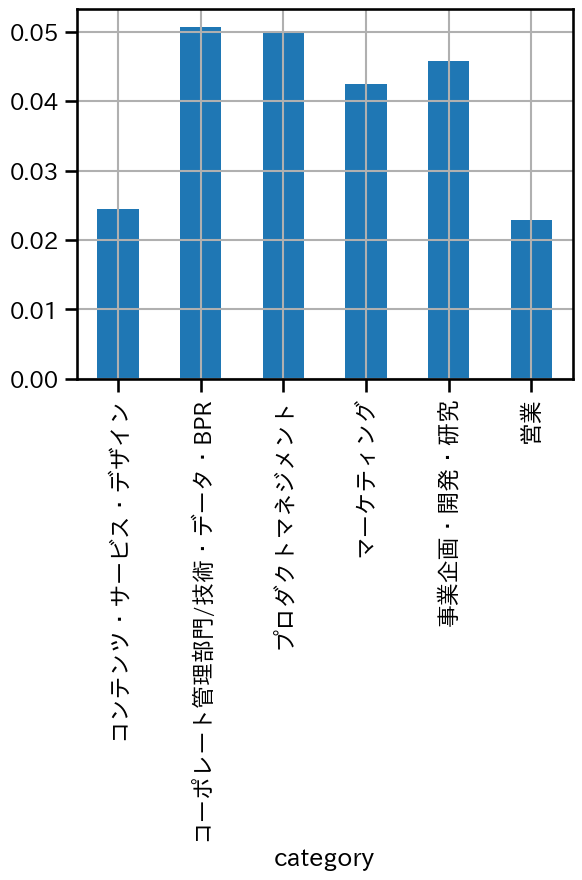

In [187]:
# 初手の可視化は目的変数から。目的変数がどのくらいの頻度で出てきているのか
ax = df_train.groupby("category")["target"].mean().plot(kind="bar")
ax.grid()

目的変数の可視化から、ポジティブデータが全体の2～5％ととても少ないことが分かる


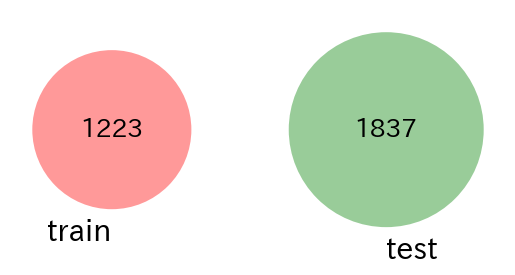

In [188]:
# データの重なりの可視化
# trainデータとtestデータで社員に重なりが無いかを確認
venn2(subsets=(set(df_train["社員番号"].unique()), set(df_test["社員番号"].unique())), set_labels=("train", "test"))

trainデータとtestデータで社員に重なりが無いことが分かる。

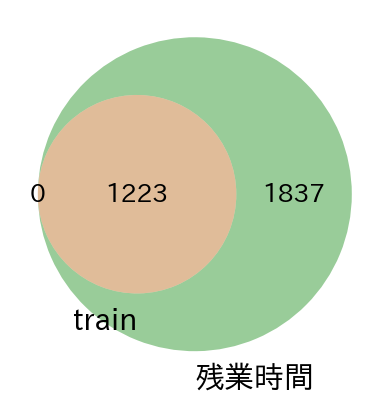

In [189]:
# 残業時間ごとに応募カテゴリの応募率はどうなっているのか？ベン図を書いてみる
venn2(subsets=(set(df_train["社員番号"].unique()), set(df_overtime["社員番号"].unique())), set_labels=("train", "残業時間"))


残業時間が無いようなtrainデータは無い。
残業時間の欠損が無いので、より機械学習に使いやすい。

他のベン図も作ってみる

C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1820460831.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  z= df_train.groupby([hours, "category"])["target"].mean().unstack()


<Axes: xlabel='category', ylabel='社員番号'>

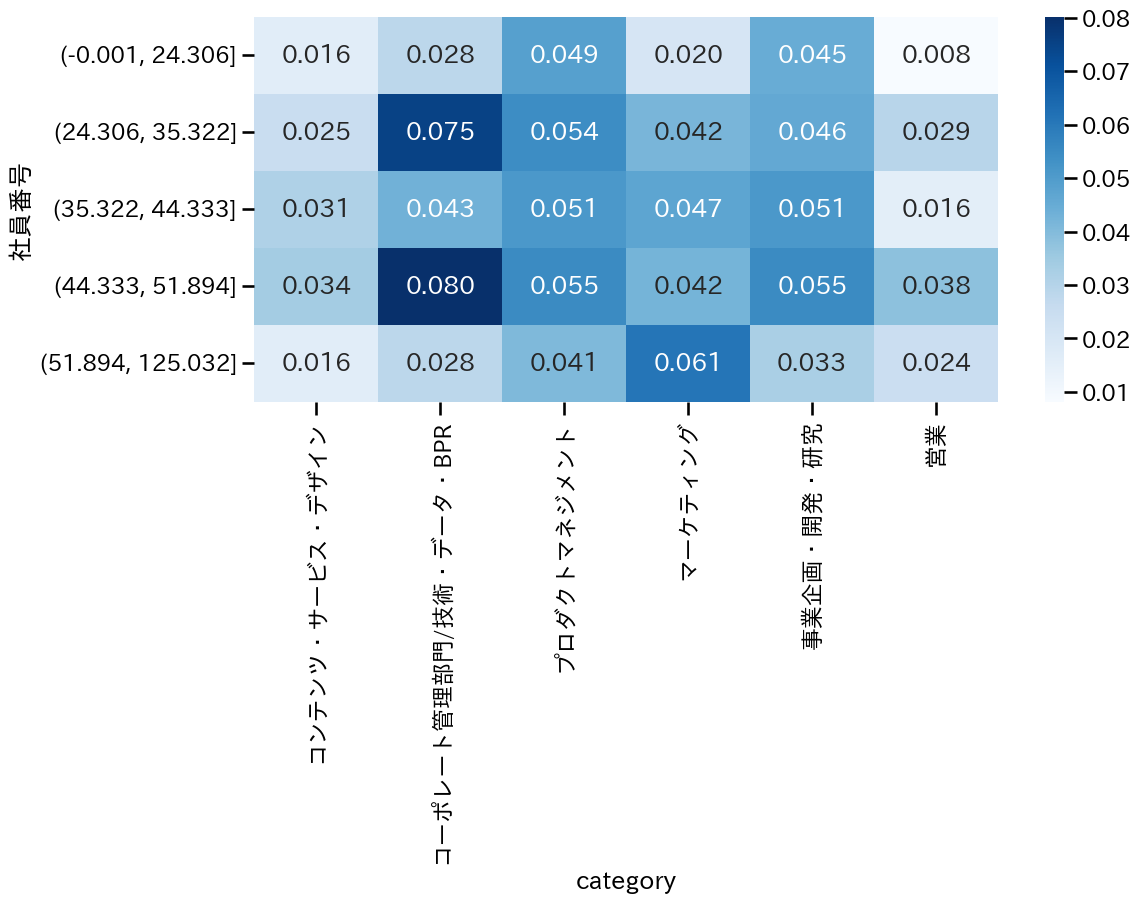

In [190]:
# 社員ごとに平均残業時間を求める
mean_hours_by_workers = df_overtime.groupby("社員番号")["hours"].mean()

# q-cutはquantile cutの略で、連続地を書く幅が同じくらいのデータになるように区切ってくれる
mean_hours_by_workers = pd.qcut(mean_hours_by_workers, q=5)
hours =df_train["社員番号"].map(mean_hours_by_workers)

# 縦軸が1人当たりの残業時間となる
z= df_train.groupby([hours, "category"])["target"].mean().unstack()

fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(z, cmap="Blues", annot=True, fmt=".3f", ax=ax)

社員ごとの残業時間の可視化により、
・マーケティングは残業時間が増えると公募が増える
・PdMや事業企画は残業時間に関わらず。
・コンテンツや営業は真ん中にピークがある
・コーポレートは真ん中にピークがある。
中程度の残業時間を持っている人が公募に手を上げやすい

## 特徴量エンジニアリング：df_position


In [191]:
# 社員番号の年度の最大から最小を引くと在籍年数になる
df_position_working_years = df_position.groupby("社員番号")["year"].max() - df_position.groupby("社員番号")["year"].min()
print(df_position_working_years)

# 在籍年数をあらたな特徴量とする関数を作成
def merge_by_worker_id(left, right):
    return pd.merge(left["社員番号"], right, on="社員番号", how="left").drop(columns=["社員番号"])


社員番号
-1sqs0GXzpPJuAVKHUUFgg==    2
-2Sq3E0WkZj8pL7jxdL3Cg==    1
-4jh26kLzkU8JFQwdeQU9w==    2
-4taxxVbT1nU-J5fHWmDfQ==    2
-5W_JQCSTAYe2gGJMuT4_w==    2
                           ..
zuplFpzBoM4c1dFy5HPXqg==    2
zwcjIiu_sqUs8akLOfuYKA==    2
zxPKKLM85QljzRfp0yisow==    2
zxY0Eflwm1tYj1Wt6vo_1g==    2
zxmtr2h4ypvsNq02K9AMJg==    2
Name: year, Length: 3060, dtype: int64


In [192]:
# 社員番号の役職のユニーク数を数えれば、役職が変化した人がいる
# 1ならずっと同じ役職。3なら年度ごとに全部違う役職
df_position_position_count= df_position.groupby("社員番号")["役職"].nunique()
print(df_position_position_count)

# 役職の変化を新たな特徴量として追加
# aggはagrigationで集約情報という意味
# 働いている年数とポジションを変えた年数は何回あるかを集計する関数
def create_positon_aggregation_feture(input_df):
    agg = pd.concat([
        (df_position.groupby("社員番号")["year"].max() - df_position.groupby("社員番号")["year"].min()),
        df_position.groupby("社員番号")["役職"].nunique().rename("change_positon_count")
    ], axis=1)

    return merge_by_worker_id(input_df, agg)

create_positon_aggregation_feture(df_train)

社員番号
-1sqs0GXzpPJuAVKHUUFgg==    2
-2Sq3E0WkZj8pL7jxdL3Cg==    1
-4jh26kLzkU8JFQwdeQU9w==    1
-4taxxVbT1nU-J5fHWmDfQ==    1
-5W_JQCSTAYe2gGJMuT4_w==    1
                           ..
zuplFpzBoM4c1dFy5HPXqg==    1
zwcjIiu_sqUs8akLOfuYKA==    2
zxPKKLM85QljzRfp0yisow==    1
zxY0Eflwm1tYj1Wt6vo_1g==    1
zxmtr2h4ypvsNq02K9AMJg==    1
Name: 役職, Length: 3060, dtype: int64


,year,change_positon_count
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
7333,2,1
7334,2,1
7335,2,1
7336,2,1


In [193]:
# 役職の最終年度の24年度の役職のみを取り出す（lastを使う）
# アンダーバーは一時的な変数を定義するときに付けることが多い
_df = df_position.groupby("社員番号").last()
print(_df)
def create_career_one_hot_encoding_feature(input_df):
    column_name = "役職"
    unique_values = df_position[column_name].unique()
    _df = df_position.groupby("社員番号").last()

    # 役職をカテゴリにする
    cat_series = pd.Categorical(_df[column_name], categories=unique_values)
    df_dummy = pd.get_dummies(cat_series, prefix=column_name)

    df_dummy.columns = df_dummy.columns.tolist()
    df_dummy["社員番号"] = _df.index

    return merge_by_worker_id(input_df, df_dummy)



print("---ワンホットエンコーディング実施---")
df_dummy = create_career_one_hot_encoding_feature(df_train)


                          year      勤務区分        役職
社員番号                                              
-1sqs0GXzpPJuAVKHUUFgg==    24       正社員  グループリーダー
-2Sq3E0WkZj8pL7jxdL3Cg==    24       正社員        一般
-4jh26kLzkU8JFQwdeQU9w==    24  正社員(管理職)        課長
-4taxxVbT1nU-J5fHWmDfQ==    24       正社員        一般
-5W_JQCSTAYe2gGJMuT4_w==    24       正社員        一般
...                        ...       ...       ...
zuplFpzBoM4c1dFy5HPXqg==    24       正社員        一般
zwcjIiu_sqUs8akLOfuYKA==    24  正社員(管理職)        部長
zxPKKLM85QljzRfp0yisow==    24       正社員        一般
zxY0Eflwm1tYj1Wt6vo_1g==    24       正社員        一般
zxmtr2h4ypvsNq02K9AMJg==    24       正社員        一般

[3060 rows x 3 columns]
---ワンホットエンコーディング実施---


<bound method _AxesBase.grid of <Axes: >>

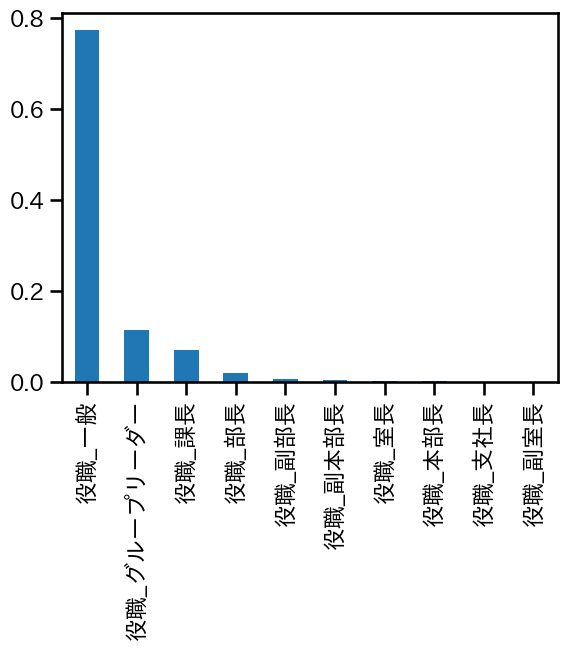

In [194]:
# ワンホットエンコーディング後の分布
ax = df_dummy.mean().plot(kind="bar")
ax.grid

In [195]:
# 

# この関数は、input_df という名前でPandasのデータフレーム (pd.DataFrame) を受け取ります
def create_category_one_hot_encoding_feture(input_df: pd.DataFrame):
    # 列の名前 ("category") を、column_name という変数に格納
    column_name = "category"
    # input_df データフレームから category 列（input_df[column_name]）を取り出し、
    # .unique() を使って重複しないカテゴリの種類をすべてリストアップ
    unique_values = input_df[column_name].unique()
    # category 列をカテゴリ型データに変換しています。
    # categories=unique_values と指定することで、カテゴリの順序を unique_values の順番に固定
    cat_series = pd.Categorical(input_df[column_name], categories=unique_values)
    # カテゴリ型のデータ (cat_series) を受け取り、ワンホットエンコーディングを実行
    df_dummy = pd.get_dummies(cat_series, prefix=column_name)
    # データフレームの列名（df_dummy.columns）を一度リスト形式に変換し、
    # それを再度列名として設定し直しています。必須ではありません。
    df_dummy.columns = df_dummy.columns.tolist()
    
    return df_dummy

create_category_one_hot_encoding_feture(df_train)

,category_コンテンツ・サービス・デザイン,category_コーポレート管理部門/技術・データ・BPR,category_プロダクトマネジメント,category_マーケティング,category_事業企画・開発・研究,category_営業
0,True,False,False,False,False,False
1,False,True,False,False,False,False
2,False,False,True,False,False,False
3,False,False,False,True,False,False
4,False,False,False,False,True,False
...,...,...,...,...,...,...
7333,False,True,False,False,False,False
7334,False,False,True,False,False,False
7335,False,False,False,True,False,False
7336,False,False,False,False,True,False


In [217]:
def create_all_advanced_pos_features(position_df):
    """
    役職履歴データから、キャリアの質や変化に関する特徴量を作成し、
    特徴量のみのデータフレームを返す。（'year'列を直接使用）
    """
    # 年でソート（year_4digitを作成しない）
    pos_df = position_df.copy()
    pos_df = pos_df.sort_values(['社員番号', 'year'])

    # 特徴量を格納するDataFrameを準備
    df_features = pd.DataFrame(index=pos_df['社員番号'].unique())
    df_features.index.name = '社員番号'

    # 昇進フラグ
    role_hierarchy = {'一般': 1, 'グループリーダー': 2, '課長': 3, '部長': 4, '本部長': 5, 'CxO': 6, 'その他': 0}
    pos_df['role_level'] = pos_df['役職'].map(role_hierarchy).fillna(0)
    pos_df['level_change'] = pos_df.groupby('社員番号')['role_level'].diff()
    df_features['pos_has_been_promoted'] = (pos_df.groupby('社員番号')['level_change'].max() > 0).astype(int)

    # --- 昇進してからの経過年数 (Promotion Recency)  ---
    # 各社員の最新年を取得
    latest_year_map = pos_df.groupby('社員番号')['year'].max()
    # 各社員が最後に昇進した年を取得
    last_promo_year = pos_df[pos_df['level_change'] > 0].groupby('社員番号')['year'].max()
    # 最新年と最後に昇進した年の差を計算
    years_since_promo = latest_year_map - last_promo_year
    df_features['pos_years_since_promotion'] = years_since_promo

    # 最新の役職情報（役職名とレベル）を一度に取得します
    latest_pos = pos_df.loc[pos_df.groupby('社員番号')['year'].idxmax()]
    latest_pos = latest_pos[['社員番号', '役職', 'role_level']].rename(columns={'役職': 'latest_role', 'role_level': 'latest_role_level'})

    # --- 現役職での在籍年数 ---
    df_merged = pd.merge(pos_df, latest_pos[['社員番号', 'latest_role']], on='社員番号', how='left')
    df_features['pos_years_in_current_role'] = df_merged[df_merged['役職'] == df_merged['latest_role']].groupby('社員番号').size()

    # --- 停滞指標 (Stagnation Index) ---
    # 修正したlatest_posを使って最新の役職レベルを取得します
    stagnation_info = latest_pos.set_index('社員番号')
    # 停滞指標を計算
    df_features['pos_stagnation_index'] = df_features['pos_years_in_current_role'] / (stagnation_info['latest_role_level'] + 1e-6)


    # 最初の役職 (OHE)
    first_pos = pos_df.loc[pos_df.groupby('社員番号')['year'].idxmin()]
    df_features = df_features.join(pd.get_dummies(first_pos.set_index('社員番号')['役職'], prefix='pos_first'))
    
    # 勤務区分の特徴量
    latest_work_type = pos_df.loc[pos_df.groupby('社員番号')['year'].idxmax()]
    df_features = df_features.join(pd.get_dummies(latest_work_type.set_index('社員番号')['勤務区分'], prefix='pos_latest_work_type'))
    df_features['pos_work_type_change_count'] = pos_df.groupby('社員番号')['勤務区分'].nunique()

    # 欠損値を埋めてから返す
    return df_features.reset_index().fillna(0)

print("関数 'create_all_advanced_pos_features' が定義されました。")


関数 'create_all_advanced_pos_features' が定義されました。


## career.csvの加工

In [218]:
# career.csvの加工
import re

# データの読み込み
df_career = pd.read_csv(os.path.join(INPUT_DIR, "career.csv"), encoding='utf-8-sig')

# 最初に、すべてのカラム名から前後の空白と改行文字を削除します
df_career.columns = df_career.columns.str.strip()

# 回答の文字列から先頭の数字を抽出する関数
def extract_score(value):
    # 値が文字列でない場合（例: 空白）も考慮
    if not isinstance(value, str):
        return np.nan
    
    # 正規表現で文字列の先頭にある数字（\d）を検索
    match = re.search(r'^\d', value.strip())
    
    if match:
        # 数字が見つかった場合、整数に変換して返す
        return int(match.group(0))
    else:
        # 数字が見つからない場合はNaN（欠損値）を返す
        return np.nan

# 社員番号以外のすべての列に関数を適用
# df_career.columns[1:] は「1列目以降のすべての列」という意味
for col in df_career.columns[1:]:
    df_career[col] = df_career[col].apply(extract_score)

# スコアを反転させるカラムのリスト
reverse_cols = [
    "自分のこれからのキャリアには、あまり関心がない\n",
    "これからのキャリアをどう歩むべきか、あまり考えていない\n",
    "納得いくキャリアを歩めない原因の大半は周囲の環境にある\n",
    "キャリアは周りの環境によって決められていくものだと思う\n"
]

# カラム名に改行文字が含まれていると表示が崩れることがあるため、
# 表示用に改行を削除したカラム名のリストを作成
display_cols = [col.strip() for col in reverse_cols]
# 元のデータフレームのカラム名も一時的に修正
df_career.columns = [col.strip() if col in reverse_cols else col for col in df_career.columns]


print("--- 🔢 スコア反転前のデータ ---")
print(df_career[display_cols].head())

# 対象となる各カラムのスコアを反転させる
for col in display_cols:
    if col in df_career.columns:
        df_career[col] = 6 - df_career[col]
    else:
        print(f"警告: カラム '{col.strip()}' が見つかりませんでした。")

print("\n" + "="*50 + "\n")

print("--- 🔄 スコア反転後のデータ ---")
print(df_career[display_cols].head())

# 処理後のデータを確認
print("--- 全ての処理が完了した後のデータ ---")
print(df_career.head())

# 各カテゴリに属するカラム名のリストを定義
feature_groups = {
    "職業的自己イメージの明確さ": [
        "自分の能力を発揮できる仕事上の得意分野が見つかっている",
        "自分はどんな仕事をやりたいのか明らかである",
        "自分は何を望んで今の仕事をしているのかわかっている",
        "自分なりの職業的な生き方に関する目標・目的がはっきりしている"
    ],
    "主体的キャリア形成意欲": [
        "自分のこれからのキャリアには、あまり関心がない",
        "これからのキャリアを、より充実したものにしたいと強く思う",
        "キャリア設計（職業生活の設計）は、自分にとって重要な課題である",
        "これからのキャリアをどう歩むべきか、あまり考えていない"
    ],
    "キャリアの自己責任自覚": [
        "納得いくキャリアを歩めるかどうかは、自分の責任だと思う",
        "キャリア形成は、自分自身の責任である",
        "納得いくキャリアを歩めない原因の大半は周囲の環境にある",
        "キャリアは周りの環境によって決められていくものだと思う"
    ],
    "職場環境変化への適応行動": [
        "新しい環境や状況にも、わりあい早くなじんで対応している",
        "職場環境の変化に対して自分なりに考えて対応している",
        "新しい職場に移ってもすぐに自分らしさを発揮している",
        "職場の制度や仕事が変わってもすぐ対応している"
    ],
    "キャリア開発行動": [
        "自分の職種・業界分野における最新動向を常に情報収集している",
        "仕事のために新しいことをいろいろ勉強している",
        "社会・経済の動きや成り行きに関する情報を、積極的に収集している",
        "新しい知識・技術を積極的に学ぶように努めている"
    ],
    "ネットワーク行動": [
        "新しい人間関係が構築できるように、社内外の活動に積極的に参加している",
        "仕事と直接関係ない人とも積極的に交流するようにしている",
        "新しいネットワークづくりに常に取り組んでいる"
    ],
    "主体的仕事行動": [
        "自分の満足感を高めるように、仕事のやり方を工夫している",
        "常に自発的に仕事を行っている",
        "自分の価値観やポリシーを持って仕事に取り組んでいる",
        "仕事の進め方や企画を立てる上で、今までの延長上のやり方ではなく、自分なりの発想を持って取り組んでいる"
    ]
}

# 新しい合計点のカラムを作成
for new_col_name, group_cols in feature_groups.items():
    # .sum(axis=1) で行ごとに合計点を計算
    df_career[new_col_name] = df_career[group_cols].sum(axis=1, min_count=1) # 1つでも有効な値があれば合計


# --- Step 3: 結果の確認 ---
print("--- 作成された新しい特徴量（合計点） ---")

# 作成した新しいカラム名だけのリスト
new_feature_columns = list(feature_groups.keys())
# 社員番号と新しいカラムだけを表示
print(df_career[["社員番号"] + new_feature_columns].head())


--- 🔢 スコア反転前のデータ ---
   自分のこれからのキャリアには、あまり関心がない  これからのキャリアをどう歩むべきか、あまり考えていない  \
0                        4                            3   
1                        1                            1   
2                        1                            1   
3                        5                            1   
4                        2                            2   

   納得いくキャリアを歩めない原因の大半は周囲の環境にある  キャリアは周りの環境によって決められていくものだと思う  
0                            3                            5  
1                            1                            1  
2                            1                            1  
3                            1                            1  
4                            1                            2  


--- 🔄 スコア反転後のデータ ---
   自分のこれからのキャリアには、あまり関心がない  これからのキャリアをどう歩むべきか、あまり考えていない  \
0                        2                            3   
1                        5                            5   
2                        5                          

In [219]:
# create_career_summary_feature という関数を作成(上記と同じ処理)
def create_career_summary_feature(input_df: pd.DataFrame, career_csv_path: str):
    """
    career.csvを読み込み、スコアの抽出、逆転項目の処理、
    カテゴリごとの合計点の算出を行い、input_dfに結合して返す関数
    """
    # --- Step 1: career.csvの読み込みと前処理 ---
    try:
        df_career = pd.read_csv(career_csv_path, encoding='utf-8-sig')
    except FileNotFoundError:
        print(f"'{career_csv_path}' が見つかりません。処理をスキップします。")
        return input_df # ファイルがない場合は元のdfをそのまま返す

    df_career.columns = df_career.columns.str.strip()

    def extract_score(value):
        if not isinstance(value, str): return np.nan
        match = re.search(r'\d', value)
        if match: return int(match.group(0))
        else: return np.nan

    for col in df_career.columns[1:]:
        df_career[col] = df_career[col].apply(extract_score)

    reverse_cols = [
        "自分のこれからのキャリアには、あまり関心がない", "これからのキャリアをどう歩むべきか、あまり考えていない",
        "納得いくキャリアを歩めない原因の大半は周囲の環境にある", "キャリアは周りの環境によって決められていくものだと思う"
    ]
    for col in reverse_cols:
        if col in df_career.columns:
            df_career[col] = 6 - df_career[col]

    # --- Step 2: 指定された項目を合計して新しい特徴量を作成 ---
    feature_groups = {
        "職業的自己イメージの明確さ": ["自分の能力を発揮できる仕事上の得意分野が見つかっている", "自分はどんな仕事をやりたいのか明らかである", "自分は何を望んで今の仕事をしているのかわかっている", "自分なりの職業的な生き方に関する目標・目的がはっきりしている"],
        "主体的キャリア形成意欲": ["自分のこれからのキャリアには、あまり関心がない", "これからのキャリアを、より充実したものにしたいと強く思う", "キャリア設計（職業生活の設計）は、自分にとって重要な課題である", "これからのキャリアをどう歩むべきか、あまり考えていない"],
        "キャリアの自己責任自覚": ["納得いくキャリアを歩めるかどうかは、自分の責任だと思う", "キャリア形成は、自分自身の責任である", "納得いくキャリアを歩めない原因の大半は周囲の環境にある", "キャリアは周りの環境によって決められていくものだと思う"],
        "職場環境変化への適応行動": ["新しい環境や状況にも、わりあい早くなじんで対応している", "職場環境の変化に対して自分なりに考えて対応している", "新しい職場に移ってもすぐに自分らしさを発揮している", "職場の制度や仕事が変わってもすぐ対応している"],
        "キャリア開発行動": ["自分の職種・業界分野における最新動向を常に情報収集している", "仕事のために新しいことをいろいろ勉強している", "社会・経済の動きや成り行きに関する情報を、積極的に収集している", "新しい知識・技術を積極的に学ぶように努めている"],
        "ネットワーク行動": ["新しい人間関係が構築できるように、社内外の活動に積極的に参加している", "仕事と直接関係ない人とも積極的に交流するようにしている", "新しいネットワークづくりに常に取り組んでいる"],
        "主的仕事行動": ["自分の満足感を高めるように、仕事のやり方を工夫している", "常に自発的に仕事を行っている", "自分の価値観やポリシーを持って仕事に取り組んでいる", "仕事の進め方や企画を立てる上で、今までの延長上のやり方ではなく、自分なりの発想を持って取り組んでいる"]
    }

    new_feature_columns = list(feature_groups.keys())
    for new_col_name, group_cols in feature_groups.items():
        df_career[new_col_name] = df_career[group_cols].sum(axis=1, min_count=1)

    # --- Step 3: input_dfに結合 ---
    # 必要なカラム（社員番号と新しい特徴量）だけを抽出
    df_career_features = df_career[["社員番号"] + new_feature_columns]
    
    # 元のデータフレームに結合して返す
    output_df = pd.merge(input_df, df_career_features, on="社員番号", how="left")
    
    return output_df


career_csv_path = os.path.join(INPUT_DIR, "career.csv")

# partialを使って、career_csv_path引数を固定した新しい関数を作成
create_career_summary_feature_fixed = partial(create_career_summary_feature, career_csv_path=career_csv_path)



## Udemy受講記録: udemy_activity.csvの加工

In [220]:
# --- 1. データの前処理 ---
print("--- データの前処理を開始 ---")

# '開始日'と'終了日'の列を日付型に変換します
# 変換できない値はNaT（Not a Time）として扱います
df_udemy['start_date'] = pd.to_datetime(df_udemy['開始日'], errors='coerce')
df_udemy['end_date'] = pd.to_datetime(df_udemy['終了日'], errors='coerce')

# '推定完了率%'と'最終結果（クイズの場合）'を数値型に変換します
df_udemy['completion_rate_percent'] = pd.to_numeric(df_udemy['推定完了率%'], errors='coerce')
df_udemy['quiz_result_percent'] = pd.to_numeric(df_udemy['最終結果（クイズの場合）'], errors='coerce')

# 'マーク済み修了'をTrue/Falseから1/0の整数に変換します
df_udemy['is_completed_marked'] = df_udemy['マーク済み修了'].astype(int)

print("日付変換と数値クレンジングが完了しました。")
# df_udemy.head()

--- データの前処理を開始 ---
日付変換と数値クレンジングが完了しました。


以下の特徴量エンジニアリングを実施
■学習量・利用状況に関する特徴量
・総受講コース数：一人の社員がいくつのユニークなコースを受講したか。
・総受講レクチャー数：視聴したレクチャーや受験したクイズの総数
・総学習時間：各レクチャーの 終了日 - 開始日 の合計時間。熱心さの指標
・学習完了率：マーク済み終了 が True のレクチャー数を、総受講レクチャー数で割った割合
■ 学習内容・分野に関する特徴量
・受講カテゴリの多様性：受講したコースカテゴリーのユニーク数。数が多いほど、幅広く学んでいる
■ 学習成果・パフォーマンスに関する特徴量
・レクチャーの平均完了率：視聴したすべてのレクチャーにおける推定完了率%の平均値
■時間・時期に関する特徴量
・最終学習日からの経過日数：最近アクティビティがない社員は、興味を失っている可能性
・学習期間：最初の開始日から最後の終了日までの期間。継続的に学習しているかどうか
・週末・平日の学習比率：業務外での自己投資意欲の指標になる可能性

In [221]:
# 社員番号ごとに集約するための準備をします
agg_funcs = {
    # 総受講コース数
    'total_courses': ('コースID', 'nunique'),
    # 総受講レクチャー数
    'total_lectures': ('社員番号', 'size'),
    # 学習完了率
    'completion_rate_marked': ('is_completed_marked', 'mean'),
    # 受講カテゴリの多様性
    'category_diversity': ('コースカテゴリー', 'nunique'),
    # レクチャーの平均完了率
    'avg_completion_rate_estimated': ('completion_rate_percent', 'mean'),
}

# groupby().agg() を使って、上記の特徴量を一度に計算します
df_udemy_features = df_udemy.groupby('社員番号').agg(**agg_funcs)


# --- 時間関連など、個別に計算が必要な特徴量 ---

# 総学習時間（単位：時間）
df_udemy['duration_seconds'] = (df_udemy['end_date'] - df_udemy['start_date']).dt.total_seconds()
total_learning_hours = df_udemy.groupby('社員番号')['duration_seconds'].sum() / 3600
df_udemy_features['total_learning_hours'] = total_learning_hours

# 最終学習日からの経過日数
latest_activity_date = df_udemy['end_date'].max()
days_since_last = (latest_activity_date - df_udemy.groupby('社員番号')['end_date'].max()).dt.days
df_udemy_features['days_since_last_activity'] = days_since_last

# 学習期間（最初と最後の学習日の差）
learning_period = (df_udemy.groupby('社員番号')['end_date'].max() - df_udemy.groupby('社員番号')['start_date'].min()).dt.days
df_udemy_features['learning_period_days'] = learning_period

# 週末の学習比率
df_udemy['is_weekend'] = df_udemy['start_date'].dt.dayofweek.isin([5, 6]).astype(int)
weekend_ratio = df_udemy.groupby('社員番号')['is_weekend'].mean()
df_udemy_features['weekend_learning_ratio'] = weekend_ratio

# 計算の過程で発生した欠損値(NaN)を0で埋めます
df_udemy_features.fillna(0, inplace=True)

print(f"\n特徴量エンジニアリングが完了しました。")

# 結果の確認のため、作成されたデータフレームの先頭5行を表示します
print("\n--- 作成された特徴量データフレーム (df_udemy_features) ---")
print(df_udemy_features.head())


特徴量エンジニアリングが完了しました。

--- 作成された特徴量データフレーム (df_udemy_features) ---
                          total_courses  total_lectures  \
社員番号                                                      
-1sqs0GXzpPJuAVKHUUFgg==              4              32   
-2Sq3E0WkZj8pL7jxdL3Cg==              5             194   
-4jh26kLzkU8JFQwdeQU9w==              2               2   
-4taxxVbT1nU-J5fHWmDfQ==             36             316   
-5W_JQCSTAYe2gGJMuT4_w==             17             146   

                          completion_rate_marked  category_diversity  \
社員番号                                                                   
-1sqs0GXzpPJuAVKHUUFgg==                0.906250                   1   
-2Sq3E0WkZj8pL7jxdL3Cg==                0.989691                   5   
-4jh26kLzkU8JFQwdeQU9w==                0.500000                   1   
-4taxxVbT1nU-J5fHWmDfQ==                0.772152                  22   
-5W_JQCSTAYe2gGJMuT4_w==                0.931507                   9   

               

## hr.csvの加工

In [222]:
# ■参加量・エンゲージメントに関する特徴量
# ・総参加施策数：一人の社員が参加した研修や面談の総回数
# ・ユニークカテゴリ参加数：何種類のカテゴリの施策に参加したか。参加の幅広さを示します
# ■参加内容・分野に関する特徴量
# ・特定カテゴリの参加回数（フラグ化）：「キャリア面談に参加した回数」「スキルアップ支援を受けた回数」などをそれぞれ独立した特徴量に
# ■時系列・タイミングに関する特徴量
# ・最終参加日からの経過日数
# ・初回参加日からの経過日数
# ・参加頻度

In [223]:
# --- 1. 前処理：実施日の整形 ---
print("--- 実施日の整形を開始 ---")
# カンマが含まれている場合は最初の部分のみ抽出し、日付型に変換
df_hr['date'] = pd.to_datetime(df_hr['実施日'].str.split(',').str[0], errors='coerce')
print("実施日の整形が完了しました。")


# --- 2. 特徴量エンジニアリング ---
print("\n--- 特徴量エンジニアリングを開始 ---")

# --- 2-1. 基本的な参加量の集計 ---
agg_funcs = {
    # 総参加施策数
    'hr_total_programs': ('社員番号', 'size'),
    # ユニークカテゴリ参加数
    'hr_unique_categories': ('カテゴリ', 'nunique')
}
df_hr_features = df_hr.groupby('社員番号').agg(**agg_funcs)


# --- 2-2. 特定カテゴリの参加回数（フラグ化）---
# pivot_tableを使い、カテゴリごとの参加回数を列として展開
category_counts = pd.pivot_table(df_hr, index='社員番号', columns='カテゴリ', aggfunc='size', fill_value=0)
# 新しいカラム名を生成（例: hr_category_キャリア面談）
category_counts.columns = ['hr_category_' + col for col in category_counts.columns]
# メインの特徴量データフレームに結合
df_hr_features = pd.merge(df_hr_features, category_counts, on='社員番号', how='left')


# --- 2-3. 日付関連の特徴量 ---
# 基準日をデータ内の最新日とする
latest_date = df_hr['date'].max()

# 社員ごとの最初と最後の日付を取得
date_summary = df_hr.groupby('社員番号')['date'].agg(['min', 'max']).rename(columns={'min': 'first_date', 'max': 'last_date'})

# 最終参加日からの経過日数
df_hr_features['hr_days_since_last_program'] = (latest_date - date_summary['last_date']).dt.days
# 初回参加日からの経過日数
df_hr_features['hr_days_since_first_program'] = (latest_date - date_summary['first_date']).dt.days


# --- 2-4. 参加頻度 ---
# 参加期間（日数）を計算（期間が0日の場合は1日とする）
program_span_days = (date_summary['last_date'] - date_summary['first_date']).dt.days.replace(0, 1)
# 参加頻度 = 総参加施策数 / 参加期間
df_hr_features['hr_program_frequency'] = df_hr_features['hr_total_programs'] / program_span_days


# 欠損値を0で埋める
df_hr_features.fillna(0, inplace=True)

print("特徴量エンジニアリングが完了しました。")

# --- 3. 結果の表示 ---
print("\n--- 作成された特徴量データフレーム (df_hr_features) ---")
# カラム数が多いため、転置して表示
print(df_hr_features.head().T)

--- 実施日の整形を開始 ---
実施日の整形が完了しました。

--- 特徴量エンジニアリングを開始 ---
特徴量エンジニアリングが完了しました。

--- 作成された特徴量データフレーム (df_hr_features) ---
社員番号                         -4taxxVbT1nU-J5fHWmDfQ==  \
hr_total_programs                            8.000000   
hr_unique_categories                         3.000000   
hr_category_2年目研修                            0.000000   
hr_category_3年目研修                            0.000000   
hr_category_3等級昇格者研修                         1.000000   
hr_category_OJTトレーナー研修                       0.000000   
hr_category_キャリア相談                           0.000000   
hr_category_キャリア面談                           0.000000   
hr_category_スキルアップ支援                         0.000000   
hr_category_ビジネススキルアップ研修                     6.000000   
hr_category_マネジメント研修                         0.000000   
hr_category_中途研修                             1.000000   
hr_category_初期育成                             0.000000   
hr_category_管理職研修                            0.000000   
hr_days_since_last_program

## dx.csvの加工

In [224]:
# 1. DX研修への参加量・エンゲージメント
# 社員がDXに対してどれだけ関心を持ち、時間を使っているかを測ります。
# DX研修の総受講回数:
# わかること: DX関連の学習に費やした総量。最も基本的なエンゲージメント指標です。
# 計算方法: groupby('社員番号').size()

# DX研修のユニークカテゴリ数:
# わかること: データ利活用、デジタルマーケティングなど、どれだけ幅広いDX分野に興味を持っているか。
# 計算方法: groupby('社員番号')['研修カテゴリ'].nunique()

# 2. 学習内容・専門性
# どのようなDXスキルを学習しているかに注目し、社員の興味の方向性や専門性を探ります。
# 実践系 vs 基礎系研修の受講回数:
# わかること: 単なる知識インプット（基礎）で終わらず、具体的なスキル習得（実践）まで踏み込んでいるか。「積極的な社員」を見つける上で非常に重要な特徴量です。
# 計算方法: 研修カテゴリ列の文字列に「実践」や「基礎」が含まれるかで判定し、それぞれの回数を集計します。

# カテゴリ別受講回数のフラグ化:
# わかること: 社員がどの専門分野に特化しているか。「データ利活用」に集中しているのか、「プロダクト開発」に関心があるのか、といった傾向を明らかにします。
# 計算方法: pivot_tableを使い、「カテゴリ_データ利活用_実践_count」のように、カテゴリごとに列を作成します。

# 3. 時系列・タイミング
# 学習のタイミングに注目し、直近の動向や継続性を評価します。
# 最終DX研修からの経過日数:
# わかること: DXへの興味が最近のものか、それとも過去のものか。直近のエンゲージメントを測る上で非常に重要です。
# 計算方法: 分析基準日から、各社員の研修実施日の最大値を引いて計算します。

# DX研修の参加頻度:
# わかること: 一時的に集中して受けたのか、継続的に長期間学び続けているのか。
# 計算方法: 総受講回数 ÷ 参加期間（最終研修日 - 初回研修日）で計算します。

In [225]:
# --- 1. 前処理：研修実施日の整形 ---
print("--- 研修実施日の整形を開始 ---")
df_dx['date'] = pd.to_datetime(df_dx['研修実施日'], errors='coerce')
# 日付が無効な行があれば削除
df_dx.dropna(subset=['date'], inplace=True)
print("研修実施日の整形が完了しました。")


# --- 2. 特徴量エンジニアリング ---
print("\n--- 特徴量エンジニアリングを開始 ---")

# --- 2-1. 基本的な参加量の集計 ---
agg_funcs = {
    # DX研修の総受講回数
    'dx_total_courses': ('社員番号', 'size'),
    # DX研修のユニークカテゴリ数
    'dx_unique_categories': ('研修カテゴリ', 'nunique')
}
df_dx_features = df_dx.groupby('社員番号').agg(**agg_funcs)


# --- 2-2. 学習内容・専門性に関する特徴量 ---
# 実践系・基礎系研修の回数
df_dx['is_practical'] = df_dx['研修カテゴリ'].str.contains('実践', na=False).astype(int)
df_dx['is_foundational'] = df_dx['研修カテゴリ'].str.contains('基礎', na=False).astype(int)

content_features = df_dx.groupby('社員番号')[['is_practical', 'is_foundational']].sum()
content_features.columns = ['dx_practical_courses_count', 'dx_foundational_courses_count']

# カテゴリ別受講回数のピボット
# カテゴリ名の/やスペースを_に置換して、列名として有効にする
df_dx['研修カテゴリ_cleaned'] = df_dx['研修カテゴリ'].str.replace('/', '_', regex=False).str.replace(' ', '_', regex=False)
category_counts = pd.pivot_table(df_dx, index='社員番号', columns='研修カテゴリ_cleaned', aggfunc='size', fill_value=0)
category_counts.columns = ['dx_category_' + col for col in category_counts.columns]


# --- 2-3. 時系列・タイミングに関する特徴量 ---
# 社員ごとの最初と最後の日付を取得
date_summary = df_dx.groupby('社員番号')['date'].agg(['min', 'max'])
date_summary.columns = ['first_date', 'last_date']

# 基準日をデータ内の最新日とする
latest_date = df_dx['date'].max()

# 最終DX研修からの経過日数
date_summary['dx_days_since_last'] = (latest_date - date_summary['last_date']).dt.days

# DX研修の参加期間
date_summary['dx_training_period_days'] = (date_summary['last_date'] - date_summary['first_date']).dt.days


# --- 3. 全ての特徴量を結合 ---
print("作成した特徴量を結合します。")
# 基本特徴量に内容特徴量を結合
df_dx_features = pd.merge(df_dx_features, content_features, on='社員番号', how='left')
# カテゴリ別回数を結合
df_dx_features = pd.merge(df_dx_features, category_counts, on='社員番号', how='left')
# 日付関連特徴量を結合
df_dx_features = pd.merge(df_dx_features, date_summary[['dx_days_since_last', 'dx_training_period_days']], on='社員番号', how='left')


# --- 2-4. 参加頻度 (結合後に計算) ---
# 参加期間が0日の場合は1日とする（ゼロ除算エラーの防止）
df_dx_features['dx_training_period_days_for_freq'] = df_dx_features['dx_training_period_days'].fillna(0).replace(0, 1)
# 参加頻度 = 総受講回数 / 参加期間
df_dx_features['dx_training_frequency'] = df_dx_features['dx_total_courses'] / df_dx_features['dx_training_period_days_for_freq']
# 計算用の一時的な列を削除
df_dx_features.drop(columns=['dx_training_period_days_for_freq'], inplace=True)


# 欠損値を0で埋める
df_dx_features.fillna(0, inplace=True)


# --- 4. 結果の表示 ---
print(f"\n特徴量エンジニアリングが完了しました。")
print("\n--- 作成された特徴量データフレーム (df_dx_features) の先頭5行 ---")
# display() はJupyter Notebook環境で綺麗に表示するための関数です
try:
    display(df_dx_features.head())
except NameError:
    print(df_dx_features.head())

--- 研修実施日の整形を開始 ---
研修実施日の整形が完了しました。

--- 特徴量エンジニアリングを開始 ---
作成した特徴量を結合します。

特徴量エンジニアリングが完了しました。

--- 作成された特徴量データフレーム (df_dx_features) の先頭5行 ---


,dx_total_courses,dx_unique_categories,dx_practical_courses_count,dx_foundational_courses_count,dx_category_DX勉強会_,dx_category_DX講演会,dx_category_システム開発_実践,dx_category_デジタルマーケティング_基礎,dx_category_データ,dx_category_データ利活用_基礎,dx_category_データ利活用_実践,dx_category_プロダクト開発_基礎,dx_category_プロダクト開発_実践,dx_category_リテラシー_DX基礎,dx_days_since_last,dx_training_period_days,dx_training_frequency
社員番号,,,,,,,,,,,,,,,,,
-2Sq3E0WkZj8pL7jxdL3Cg==,2,1,0,2,0,0,0,0,0,0,0,0,0,2,237,1,2.000000
-5W_JQCSTAYe2gGJMuT4_w==,5,2,0,4,0,1,0,0,0,0,0,0,0,4,10,589,0.008489
-AUHIuzsGtdhhsPuX6dGLw==,2,2,0,2,0,0,0,1,0,0,0,1,0,0,823,58,0.034483
-EtuCRccKFQgi3UfXRvRkA==,1,1,0,0,0,1,0,0,0,0,0,0,0,0,10,0,1.000000
-GM1IvFNvQzu80HypdRkZA==,1,1,0,1,0,0,0,0,0,0,0,1,0,0,832,0,1.000000


## overtime_work_by_month.csvの加工

In [226]:
def make_worker_hours_lag_features(df_overtime, lag=35):
    """
    社員別の過去労働時間（lag特徴量）を作成し、最新月の1行にまとめる。

    Parameters:
        df_overtime: DataFrame
            '社員番号', 'date', 'hours' を含むDataFrame（dateは昇順が前提）
        lag: int
            生成する最大lag数（例：35であれば hours_1_age ～ hours_35_age）

    Returns:
        df_worker_lag: DataFrame
            社員番号ごとの最新行 + lag特徴量（hours_0_age ～ hours_{lag}_age）
    """
    df = df_overtime.copy()
    df = df.sort_values(['社員番号', 'date']).reset_index(drop=True)

    # lag特徴量を生成
    for i in range(1, lag + 1):
        df[f'hours_{i}_age'] = df.groupby('社員番号')['hours'].shift(i)

    # 最新行を抽出
    df_worker_lag = df.groupby('社員番号').tail(1).reset_index(drop=True)

    # カラム整形
    lag_cols = [f'hours_{i}_age' for i in range(1, lag + 1)]
    df_worker_lag = df_worker_lag[['社員番号', 'date', 'hours'] + lag_cols]
    df_worker_lag = df_worker_lag.rename(columns={'hours': 'hours_0_age'})

    return df_worker_lag
df_worker_lag = make_worker_hours_lag_features(df_overtime, lag=35)
df_worker_lag.drop('date', axis=1, inplace=True)
df_worker_lag.head()



,社員番号,hours_0_age,hours_1_age,hours_2_age,hours_3_age,hours_4_age,hours_5_age,hours_6_age,hours_7_age,hours_8_age,...,hours_26_age,hours_27_age,hours_28_age,hours_29_age,hours_30_age,hours_31_age,hours_32_age,hours_33_age,hours_34_age,hours_35_age
0,-1sqs0GXzpPJuAVKHUUFgg==,43.0,17.0,55.0,51.0,15.0,44.0,44.0,19.0,0.0,...,12.0,23.0,29.0,32.0,38.0,27.0,30.0,18.0,11.0,10.0
1,-2Sq3E0WkZj8pL7jxdL3Cg==,46.0,29.0,18.0,7.0,0.0,0.0,0.0,13.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-4jh26kLzkU8JFQwdeQU9w==,53.0,65.0,67.0,61.0,19.0,51.0,46.0,46.0,44.0,...,45.0,52.0,39.0,46.0,57.0,40.0,48.0,45.0,40.0,54.0
3,-4taxxVbT1nU-J5fHWmDfQ==,60.0,60.0,60.0,59.0,60.0,59.0,59.0,60.0,56.0,...,56.0,59.0,49.0,56.0,41.0,61.0,45.0,56.0,40.0,31.0
4,-5W_JQCSTAYe2gGJMuT4_w==,57.0,60.0,73.0,54.0,49.0,93.0,65.0,65.0,31.0,...,32.0,37.0,52.0,46.0,29.0,28.0,27.0,45.0,19.0,24.0


In [227]:
from sklearn.linear_model import LinearRegression

# 各種統計特徴量を生成するウィンドウサイズのリスト
windows = [2, 3, 4, 5, 6, 9, 12, 15, 18, 24, 36]
current_hours = df_worker_lag['hours_0_age']

for w in windows:
    print(w)

    # 直近 w ヶ月分の hours列（hours_0_age ～ hours_{w-1}_age）
    cols = [f'hours_{i}_age' for i in range(0, w)]

    # 基本統計量
    df_worker_lag[f'hours_ma_{w}'] = df_worker_lag[cols].mean(axis=1)              # 平均
    df_worker_lag[f'hours_std_{w}'] = df_worker_lag[cols].std(axis=1)              # 標準偏差
    df_worker_lag[f'hours_max_{w}'] = df_worker_lag[cols].max(axis=1)              # 最大値
    df_worker_lag[f'hours_min_{w}'] = df_worker_lag[cols].min(axis=1)              # 最小値
    df_worker_lag[f'hours_diff_ma_{w}'] = current_hours - df_worker_lag[f'hours_ma_{w}']  # 今月と平均の差
    df_worker_lag[f'hours_range_{w}'] = df_worker_lag[f'hours_max_{w}'] - df_worker_lag[f'hours_min_{w}']  # 振れ幅
    df_worker_lag[f'hours_missing_count_{w}'] = df_worker_lag[cols].isna().sum(axis=1)  # 欠損数
    df_worker_lag[f'hours_zscore_{w}'] = (current_hours - df_worker_lag[f'hours_ma_{w}']) / (df_worker_lag[f'hours_std_{w}'] + 1e-6)  # z-score

    # 今月と wヶ月前との比較（差分）
    df_worker_lag[f'hours_diff_prev_{w}'] = current_hours - df_worker_lag[f'hours_{w-1}_age']

    # 線形トレンド（回帰直線の傾き）を算出
    trends = []
    for _, row in df_worker_lag[cols].iterrows():
        y = row.values
        x = np.arange(1, w + 1).reshape(-1, 1)
        if np.isnan(y).all():
            trends.append(np.nan)
        else:
            mask = ~np.isnan(y)
            reg = LinearRegression().fit(x[mask], y[mask])
            trends.append(reg.coef_[0])
    df_worker_lag[f'hours_trend_{w}'] = trends

    # 今月が過去平均より ±30% を超えているか
    ratio = current_hours / (df_worker_lag[f'hours_ma_{w}'] + 1e-6)
    df_worker_lag[f'hours_over_{w}_flag'] = (ratio > 1.3).astype(int)   # 今月が30%以上多い
    df_worker_lag[f'hours_under_{w}_flag'] = (ratio < 0.7).astype(int)  # 今月が30%以上少ない

    # 指数移動平均（最近の値をより重視した平均）
    df_worker_lag[f'hours_ewm_{w}'] = df_worker_lag[cols].T.ewm(span=3, axis=0).mean().iloc[-1]
df_worker_lag.head()

2


C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:45: FutureWarning: The 'axis' keyword in DataFrame.ewm is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  df_worker_lag[f'hours_ewm_{w}'] = df_worker_lag[cols].T.ewm(span=3, axis=0).mean().iloc[-1]


3


C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:45: FutureWarning: The 'axis' keyword in DataFrame.ewm is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  df_worker_lag[f'hours_ewm_{w}'] = df_worker_lag[cols].T.ewm(span=3, axis=0).mean().iloc[-1]


4


C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:45: FutureWarning: The 'axis' keyword in DataFrame.ewm is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  df_worker_lag[f'hours_ewm_{w}'] = df_worker_lag[cols].T.ewm(span=3, axis=0).mean().iloc[-1]


5


C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:45: FutureWarning: The 'axis' keyword in DataFrame.ewm is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  df_worker_lag[f'hours_ewm_{w}'] = df_worker_lag[cols].T.ewm(span=3, axis=0).mean().iloc[-1]


6


C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:45: FutureWarning: The 'axis' keyword in DataFrame.ewm is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  df_worker_lag[f'hours_ewm_{w}'] = df_worker_lag[cols].T.ewm(span=3, axis=0).mean().iloc[-1]


9


C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:45: FutureWarning: The 'axis' keyword in DataFrame.ewm is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  df_worker_lag[f'hours_ewm_{w}'] = df_worker_lag[cols].T.ewm(span=3, axis=0).mean().iloc[-1]


12


C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:45: FutureWarning: The 'axis' keyword in DataFrame.ewm is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  df_worker_lag[f'hours_ewm_{w}'] = df_worker_lag[cols].T.ewm(span=3, axis=0).mean().iloc[-1]
C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag[f'hours_zscore_{w}'] = (current_hours - df_worker_lag[f'hours_ma_{w}']) / (df_worker_lag[f'hours_std_{w}'] + 1e-6)  # z-score
C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

15


C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag[f'hours_trend_{w}'] = trends
C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag[f'hours_over_{w}_flag'] = (ratio > 1.3).astype(int)   # 今月が30%以上多い
C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

18


C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag[f'hours_trend_{w}'] = trends
C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag[f'hours_over_{w}_flag'] = (ratio > 1.3).astype(int)   # 今月が30%以上多い
C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

24


C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag[f'hours_trend_{w}'] = trends
C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag[f'hours_over_{w}_flag'] = (ratio > 1.3).astype(int)   # 今月が30%以上多い
C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

36


C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag[f'hours_trend_{w}'] = trends
C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag[f'hours_over_{w}_flag'] = (ratio > 1.3).astype(int)   # 今月が30%以上多い
C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\1402336123.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

,社員番号,hours_0_age,hours_1_age,hours_2_age,hours_3_age,hours_4_age,hours_5_age,hours_6_age,hours_7_age,hours_8_age,...,hours_min_36,hours_diff_ma_36,hours_range_36,hours_missing_count_36,hours_zscore_36,hours_diff_prev_36,hours_trend_36,hours_over_36_flag,hours_under_36_flag,hours_ewm_36
0,-1sqs0GXzpPJuAVKHUUFgg==,43.0,17.0,55.0,51.0,15.0,44.0,44.0,19.0,0.0,...,0.0,17.166667,55.0,0,1.026691,33.0,-0.517889,1,0,13.745152
1,-2Sq3E0WkZj8pL7jxdL3Cg==,46.0,29.0,18.0,7.0,0.0,0.0,0.0,13.0,32.0,...,0.0,20.458333,94.0,12,0.982723,NaN,1.332609,1,0,43.487298
2,-4jh26kLzkU8JFQwdeQU9w==,53.0,65.0,67.0,61.0,19.0,51.0,46.0,46.0,44.0,...,0.0,10.861111,67.0,0,0.710694,-1.0,-0.016345,0,0,48.467420
3,-4taxxVbT1nU-J5fHWmDfQ==,60.0,60.0,60.0,59.0,60.0,59.0,59.0,60.0,56.0,...,31.0,4.638889,30.0,0,0.671506,29.0,-0.422523,0,0,38.709950
4,-5W_JQCSTAYe2gGJMuT4_w==,57.0,60.0,73.0,54.0,49.0,93.0,65.0,65.0,31.0,...,19.0,11.222222,74.0,0,0.667523,33.0,-0.890347,0,0,26.091069


In [228]:
# 前月との労働時間差が閾値を超えた回数（35ヶ月分で）スパイク（急変動）のカウント
spike_threshold = 20
spike_count = []

for _, row in df_worker_lag.iterrows():
    diffs = []
    for i in range(1, 35):
        col_now = f'hours_{i}_age'
        col_next = f'hours_{i+1}_age'
        if pd.notna(row[col_now]) and pd.notna(row[col_next]):
            if abs(row[col_now] - row[col_next]) > spike_threshold:
                diffs.append(1)
    spike_count.append(sum(diffs))

df_worker_lag['hours_spike_count'] = spike_count
df_worker_lag.head()

C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\3977662040.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag['hours_spike_count'] = spike_count


,社員番号,hours_0_age,hours_1_age,hours_2_age,hours_3_age,hours_4_age,hours_5_age,hours_6_age,hours_7_age,hours_8_age,...,hours_diff_ma_36,hours_range_36,hours_missing_count_36,hours_zscore_36,hours_diff_prev_36,hours_trend_36,hours_over_36_flag,hours_under_36_flag,hours_ewm_36,hours_spike_count
0,-1sqs0GXzpPJuAVKHUUFgg==,43.0,17.0,55.0,51.0,15.0,44.0,44.0,19.0,0.0,...,17.166667,55.0,0,1.026691,33.0,-0.517889,1,0,13.745152,8
1,-2Sq3E0WkZj8pL7jxdL3Cg==,46.0,29.0,18.0,7.0,0.0,0.0,0.0,13.0,32.0,...,20.458333,94.0,12,0.982723,NaN,1.332609,1,0,43.487298,4
2,-4jh26kLzkU8JFQwdeQU9w==,53.0,65.0,67.0,61.0,19.0,51.0,46.0,46.0,44.0,...,10.861111,67.0,0,0.710694,-1.0,-0.016345,0,0,48.467420,8
3,-4taxxVbT1nU-J5fHWmDfQ==,60.0,60.0,60.0,59.0,60.0,59.0,59.0,60.0,56.0,...,4.638889,30.0,0,0.671506,29.0,-0.422523,0,0,38.709950,0
4,-5W_JQCSTAYe2gGJMuT4_w==,57.0,60.0,73.0,54.0,49.0,93.0,65.0,65.0,31.0,...,11.222222,74.0,0,0.667523,33.0,-0.890347,0,0,26.091069,8


In [229]:
# 増減方向のトレンド
def direction_mode(row, window=6):
    """
    過去 window ヶ月分の労働時間（hours_{i}_age）を比較し、
    増減方向の多数決に基づいてトレンド方向を判定する。

    返す値:
        1  → 全体として上昇傾向
       -1  → 全体として下降傾向
        0  → 増減バラバラ or 相殺（中立）

    Parameters:
        row: pd.Series
        window: int (比較対象の月数)

    Returns:
        int: -1 / 0 / 1（下降 / 中立 / 上昇）
    """
    directions = []
    for i in range(0, window - 1):
        a, b = row.get(f'hours_{i}_age'), row.get(f'hours_{i+1}_age')
        if pd.notna(a) and pd.notna(b):
            # 増加なら +1、減少なら -1、変化なしなら 0
            directions.append(np.sign(a - b))

    if not directions:
        return 0  # 比較できるペアがない場合は中立とする

    # 合計符号の sign → 全体傾向の方向
    return int(np.sign(sum(directions)))

df_worker_lag['hours_trend_mode_6'] = df_worker_lag.apply(direction_mode, axis=1, args=(6,))
df_worker_lag.head(5)

C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\526801703.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag['hours_trend_mode_6'] = df_worker_lag.apply(direction_mode, axis=1, args=(6,))


,社員番号,hours_0_age,hours_1_age,hours_2_age,hours_3_age,hours_4_age,hours_5_age,hours_6_age,hours_7_age,hours_8_age,...,hours_range_36,hours_missing_count_36,hours_zscore_36,hours_diff_prev_36,hours_trend_36,hours_over_36_flag,hours_under_36_flag,hours_ewm_36,hours_spike_count,hours_trend_mode_6
0,-1sqs0GXzpPJuAVKHUUFgg==,43.0,17.0,55.0,51.0,15.0,44.0,44.0,19.0,0.0,...,55.0,0,1.026691,33.0,-0.517889,1,0,13.745152,8,1
1,-2Sq3E0WkZj8pL7jxdL3Cg==,46.0,29.0,18.0,7.0,0.0,0.0,0.0,13.0,32.0,...,94.0,12,0.982723,NaN,1.332609,1,0,43.487298,4,1
2,-4jh26kLzkU8JFQwdeQU9w==,53.0,65.0,67.0,61.0,19.0,51.0,46.0,46.0,44.0,...,67.0,0,0.710694,-1.0,-0.016345,0,0,48.467420,8,-1
3,-4taxxVbT1nU-J5fHWmDfQ==,60.0,60.0,60.0,59.0,60.0,59.0,59.0,60.0,56.0,...,30.0,0,0.671506,29.0,-0.422523,0,0,38.709950,0,1
4,-5W_JQCSTAYe2gGJMuT4_w==,57.0,60.0,73.0,54.0,49.0,93.0,65.0,65.0,31.0,...,74.0,0,0.667523,33.0,-0.890347,0,0,26.091069,8,-1


## 特徴量エンジニアリングを実施したデータフレームを結合する

In [230]:

def build_feature(input_df: pd.DataFrame, feature_functions: List) -> pd.DataFrame:
    # カラのデータフレームを用意
    out_df = pd.DataFrame()
    print("start build feature...")


    # 各特徴生成関数事で
    for func in feature_functions:

        # funcがpartialオブジェクトか、通常の関数かで名前の取得方法を分ける
        if isinstance(func, partial):
            # partialの場合、.func.__name__ で元の関数名を取得
            func_name = func.func.__name__
        else:
            # 通常の関数の場合、.__name__ で名前を取得
            func_name = func.__name__

        with Timer(prefix=f"create {func_name}"):
            # 特徴量を作成
            _df = func(input_df)

        # 横方向axis=1で結合
        out_df = pd.concat([out_df, _df], axis=1)
    return out_df

In [231]:
# 作成した特徴量をfunctionsにまとめる
functions = [
    create_career_one_hot_encoding_feature,
    create_positon_aggregation_feture,
    create_category_one_hot_encoding_feture,
    create_career_summary_feature_fixed,
]

In [232]:
# functionsをがっちゃんこする
with Timer(prefix="build train..."):
    df_train_feat = build_feature(df_train, feature_functions=functions)

with Timer(prefix="build test..."):
    df_test_feat = build_feature(df_test, feature_functions=functions)


start build feature...
create create_career_one_hot_encoding_feature 0.021[s]
create create_positon_aggregation_feture 0.018[s]
create create_category_one_hot_encoding_feture 0.004[s]
create create_career_summary_feature 0.089[s]
build train... 0.146[s]
start build feature...
create create_career_one_hot_encoding_feature 0.016[s]
create create_positon_aggregation_feture 0.016[s]
create create_category_one_hot_encoding_feture 0.000[s]
create create_career_summary_feature 0.072[s]
build test... 0.103[s]


## 人力でデータフレームを結合していく

In [233]:
# 作成した労働時間の特徴量(df_worker_lag)を結合する
with Timer(prefix="merge worker lag features..."):
    print("--- 労働時間の特徴量を結合 ---")
    
    # 訓練データに結合
    df_train_feat = pd.merge(df_train_feat, df_worker_lag, on='社員番号', how='left')
    print(f"訓練データ 結合後のshape: {df_train_feat.shape}")

    # テストデータに結合
    df_test_feat = pd.merge(df_test_feat, df_worker_lag, on='社員番号', how='left')
    print(f"テストデータ 結合後のshape: {df_test_feat.shape}")

# 結合後のデータフレームの先頭を表示して、正しく結合されているか確認
print("\n--- 結合後の訓練データ (先頭5行) ---")
display(df_train_feat.head())

--- 労働時間の特徴量を結合 ---
訓練データ 結合後のshape: (7338, 209)
テストデータ 結合後のshape: (11022, 208)
merge worker lag features... 0.120[s]

--- 結合後の訓練データ (先頭5行) ---


,役職_一般,役職_グループリーダー,役職_課長,役職_部長,役職_副部長,役職_副本部長,役職_室長,役職_本部長,役職_支社長,役職_副室長,...,hours_range_36,hours_missing_count_36,hours_zscore_36,hours_diff_prev_36,hours_trend_36,hours_over_36_flag,hours_under_36_flag,hours_ewm_36,hours_spike_count,hours_trend_mode_6
0,True,False,False,False,False,False,False,False,False,False,...,94.0,12,0.982723,NaN,1.332609,1,0,43.487298,4,1
1,True,False,False,False,False,False,False,False,False,False,...,94.0,12,0.982723,NaN,1.332609,1,0,43.487298,4,1
2,True,False,False,False,False,False,False,False,False,False,...,94.0,12,0.982723,NaN,1.332609,1,0,43.487298,4,1
3,True,False,False,False,False,False,False,False,False,False,...,94.0,12,0.982723,NaN,1.332609,1,0,43.487298,4,1
4,True,False,False,False,False,False,False,False,False,False,...,94.0,12,0.982723,NaN,1.332609,1,0,43.487298,4,1


In [234]:
# df_udemy_featuresをマージする前に、インデックスになっている「社員番号」を列に戻します
df_udemy_features.reset_index(inplace=True)

# 作成したUdemyの学習特徴量(df_udemy_features)を結合する
with Timer(prefix="merge udemy features..."):
    print("--- Udemyの学習特徴量を結合 ---")
    
    # 訓練データに結合
    df_train_feat = pd.merge(df_train_feat, df_udemy_features, on='社員番号', how='left')
    print(f"訓練データ 結合後のshape: {df_train_feat.shape}")

    # テストデータに結合
    df_test_feat = pd.merge(df_test_feat, df_udemy_features, on='社員番号', how='left')
    print(f"テストデータ 結合後のshape: {df_test_feat.shape}")

# 結合後のデータフレームの先頭を表示して、正しく結合されているか確認
print("\n--- 結合後の訓練データ (先頭5行) ---")
display(df_train_feat.head())

--- Udemyの学習特徴量を結合 ---
訓練データ 結合後のshape: (7338, 218)
テストデータ 結合後のshape: (11022, 217)
merge udemy features... 0.050[s]

--- 結合後の訓練データ (先頭5行) ---


,役職_一般,役職_グループリーダー,役職_課長,役職_部長,役職_副部長,役職_副本部長,役職_室長,役職_本部長,役職_支社長,役職_副室長,...,hours_trend_mode_6,total_courses,total_lectures,completion_rate_marked,category_diversity,avg_completion_rate_estimated,total_learning_hours,days_since_last_activity,learning_period_days,weekend_learning_ratio
0,True,False,False,False,False,False,False,False,False,False,...,1,5.0,194.0,0.989691,5.0,99.678646,28.3,277.0,282.0,0.0
1,True,False,False,False,False,False,False,False,False,False,...,1,5.0,194.0,0.989691,5.0,99.678646,28.3,277.0,282.0,0.0
2,True,False,False,False,False,False,False,False,False,False,...,1,5.0,194.0,0.989691,5.0,99.678646,28.3,277.0,282.0,0.0
3,True,False,False,False,False,False,False,False,False,False,...,1,5.0,194.0,0.989691,5.0,99.678646,28.3,277.0,282.0,0.0
4,True,False,False,False,False,False,False,False,False,False,...,1,5.0,194.0,0.989691,5.0,99.678646,28.3,277.0,282.0,0.0


In [235]:
# df_hr_featuresをマージする前に、インデックスになっている「社員番号」を列に戻します
df_hr_features.reset_index(inplace=True)

# 作成した人事施策の特徴量(df_hr_features)を結合する
with Timer(prefix="merge hr features..."):
    print("--- 人事施策の特徴量を結合 ---")
    
    # 訓練データに結合
    df_train_feat = pd.merge(df_train_feat, df_hr_features, on='社員番号', how='left')
    print(f"訓練データ 結合後のshape: {df_train_feat.shape}")

    # テストデータに結合
    df_test_feat = pd.merge(df_test_feat, df_hr_features, on='社員番号', how='left')
    print(f"テストデータ 結合後のshape: {df_test_feat.shape}")

# 結合後のデータフレームの先頭を表示して、正しく結合されているか確認
print("\n--- 結合後の訓練データ (先頭5行) ---")
display(df_train_feat.head())

--- 人事施策の特徴量を結合 ---
訓練データ 結合後のshape: (7338, 235)
テストデータ 結合後のshape: (11022, 234)
merge hr features... 0.047[s]

--- 結合後の訓練データ (先頭5行) ---


,役職_一般,役職_グループリーダー,役職_課長,役職_部長,役職_副部長,役職_副本部長,役職_室長,役職_本部長,役職_支社長,役職_副室長,...,hr_category_キャリア面談,hr_category_スキルアップ支援,hr_category_ビジネススキルアップ研修,hr_category_マネジメント研修,hr_category_中途研修,hr_category_初期育成,hr_category_管理職研修,hr_days_since_last_program,hr_days_since_first_program,hr_program_frequency
0,True,False,False,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,False,False,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,False,False,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,False,False,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,False,False,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [236]:
# df_dx_featuresをマージする前に、インデックスになっている「社員番号」を列に戻します
df_dx_features.reset_index(inplace=True)

# 作成したDX研修の特徴量(df_dx_features)を結合する
with Timer(prefix="merge dx features..."):
    print("--- DX研修の特徴量を結合 ---")
    
    # 訓練データに結合
    df_train_feat = pd.merge(df_train_feat, df_dx_features, on='社員番号', how='left')
    print(f"訓練データ 結合後のshape: {df_train_feat.shape}")

    # テストデータに結合
    df_test_feat = pd.merge(df_test_feat, df_dx_features, on='社員番号', how='left')
    print(f"テストデータ 結合後のshape: {df_test_feat.shape}")

# 結合後のデータフレームの先頭を表示して、正しく結合されているか確認
print("\n--- 結合後の訓練データ (先頭5行) ---")
display(df_train_feat.head())

--- DX研修の特徴量を結合 ---
訓練データ 結合後のshape: (7338, 252)
テストデータ 結合後のshape: (11022, 251)
merge dx features... 0.047[s]

--- 結合後の訓練データ (先頭5行) ---


,役職_一般,役職_グループリーダー,役職_課長,役職_部長,役職_副部長,役職_副本部長,役職_室長,役職_本部長,役職_支社長,役職_副室長,...,dx_category_デジタルマーケティング_基礎,dx_category_データ,dx_category_データ利活用_基礎,dx_category_データ利活用_実践,dx_category_プロダクト開発_基礎,dx_category_プロダクト開発_実践,dx_category_リテラシー_DX基礎,dx_days_since_last,dx_training_period_days,dx_training_frequency
0,True,False,False,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,237.0,1.0,2.0
1,True,False,False,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,237.0,1.0,2.0
2,True,False,False,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,237.0,1.0,2.0
3,True,False,False,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,237.0,1.0,2.0
4,True,False,False,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,237.0,1.0,2.0


In [237]:
# position_history.csvの特徴量エンジニアリングの結果を融合
# --- 2. 関数を実行して、特徴量データフレームを作成 ---
with Timer(prefix="create advanced position features..."):
    df_advanced_pos_features = create_all_advanced_pos_features(df_position)


# --- 3. 作成した特徴量を訓練・テストデータに結合 ---
# (ご提示いただいたコードを参考にしています)
with Timer(prefix="merge advanced position features..."):
    print("--- キャリア変化に関する特徴量を結合 ---")
    
    # 訓練データに結合
    df_train_feat = pd.merge(df_train_feat, df_advanced_pos_features, on='社員番号', how='left')
    print(f"訓練データ 結合後のshape: {df_train_feat.shape}")

    # テストデータに結合
    df_test_feat = pd.merge(df_test_feat, df_advanced_pos_features, on='社員番号', how='left')
    print(f"テストデータ 結合後のshape: {df_test_feat.shape}")

# 結合後のデータフレームの先頭を表示して、正しく結合されているか確認
print("\n--- 結合後の訓練データ (先頭5行) ---")
display(df_train_feat.head())

create advanced position features... 0.565[s]
--- キャリア変化に関する特徴量を結合 ---
訓練データ 結合後のshape: (7338, 268)
テストデータ 結合後のshape: (11022, 267)
merge advanced position features... 0.032[s]

--- 結合後の訓練データ (先頭5行) ---


,役職_一般,役職_グループリーダー,役職_課長,役職_部長,役職_副部長,役職_副本部長,役職_室長,役職_本部長,役職_支社長,役職_副室長,...,pos_first_副室長,pos_first_副本部長,pos_first_副部長,pos_first_室長,pos_first_本部長,pos_first_課長,pos_first_部長,pos_latest_work_type_正社員,pos_latest_work_type_正社員(管理職),pos_work_type_change_count
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,1
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,1
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,1
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,1
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,1


In [238]:
# 「キャリア感アンケート回答有無」特徴量の作成とデータフレームの結合

# --- 1. アンケートに回答した社員のリストを作成 ---
answered_workers = df_career['社員番号'].unique()

# --- 2. 訓練データに「回答有無」の特徴量を追加 ---
# df_train_featの'社員番号'が回答者リストに含まれていれば1, そうでなければ0
df_train_feat['career_answered_flag'] = df_train_feat['社員番号'].isin(answered_workers).astype(int)


# --- 3. テストデータに「回答有無」の特徴量を追加 ---
df_test_feat['career_answered_flag'] = df_test_feat['社員番号'].isin(answered_workers).astype(int)


# --- 4. 結果の確認 ---
print("--- 「career_answered_flag」が追加されました ---")

# 訓練データのフラグの内訳を表示
print("\n▼ 訓練データの回答有無フラグ内訳")
print(df_train_feat['career_answered_flag'].value_counts())

# テストデータのフラグの内訳を表示
print("\n▼ テストデータの回答有無フラグ内訳")
print(df_test_feat['career_answered_flag'].value_counts())

# データフレームの先頭を表示して列が追加されたことを確認
print("\n▼ 特徴量追加後の訓練データ（先頭）")
display(df_train_feat[['社員番号', 'career_answered_flag']].head())

--- 「career_answered_flag」が追加されました ---

▼ 訓練データの回答有無フラグ内訳
career_answered_flag
0    6360
1     978
Name: count, dtype: int64

▼ テストデータの回答有無フラグ内訳
career_answered_flag
0    9750
1    1272
Name: count, dtype: int64

▼ 特徴量追加後の訓練データ（先頭）


,社員番号,career_answered_flag
0,-2Sq3E0WkZj8pL7jxdL3Cg==,0
1,-2Sq3E0WkZj8pL7jxdL3Cg==,0
2,-2Sq3E0WkZj8pL7jxdL3Cg==,0
3,-2Sq3E0WkZj8pL7jxdL3Cg==,0
4,-2Sq3E0WkZj8pL7jxdL3Cg==,0


In [239]:
# --- どのカラムが一致していないかを確認 ---

# 各データフレームのカラムをセット（重複のないリスト）として取得
train_cols = set(df_train_feat.columns)
test_cols = set(df_test_feat.columns)

# 学習データにのみ存在するカラムを特定
only_in_train = train_cols - test_cols
if only_in_train:
    print(f"▼ 学習データにのみ存在するカラム ({len(only_in_train)}個):")
    # 見やすいように1つずつ表示
    for col in sorted(list(only_in_train)):
        print(f"  - {col}")
else:
    print("✅ 学習データにのみ存在するカラムはありません。")

print("\n" + "="*50 + "\n")

# テストデータにのみ存在するカラムを特定
only_in_test = test_cols - train_cols
if only_in_test:
    print(f"▼ テストデータにのみ存在するカラム ({len(only_in_test)}個):")
    # 見やすいように1つずつ表示
    for col in sorted(list(only_in_test)):
        print(f"  - {col}")
else:
    print("✅ テストデータにのみ存在するカラムはありません。")

# # trainとtestのカラムが完全に一致していることを確認する。列数がずれていたら分かるようになる。
# assert df_train_feat.columns.equals(df_test_feat.columns)

▼ 学習データにのみ存在するカラム (1個):
  - target


✅ テストデータにのみ存在するカラムはありません。


In [240]:
# モデルの作成(LightGBM)
# 
def fit_lgbm(X,
             y,
             cv,
             params: dict=None,
             verbose: int=50):
    # パラメータがない時は、空のdictで置き換える
    if params is None:
        params = {}
    
    models = []
    n_records = len(X)
    # training data のtargetと同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        # 交差検定。cv instanceで分割する
        # trainingデータをtrain/validに分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)

        with Timer(prefix="fit fold={}".format(i)):
            clf.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)],
                    callbacks=[lgbm.callback.early_stopping(stopping_rounds=100),
                        lgbm.log_evaluation(period=verbose),],)

        # 予測確率を出力してもらう
        pred_i =clf.predict_proba(x_valid)
        # outputの形はsape = (n_samples, 2)になっていることに注意する
        y_pred_prob = pred_i[:, 1]

        oof_pred[idx_valid] = y_pred_prob
        models.append(clf)

        # 今回の指標のMAEで計算する
        score = roc_auc_score(y_valid, y_pred_prob, )
        print(f" -fold{i} - {score:.4f}")
    return oof_pred, models

#  モデル学習のための最終的なデータ準備
print("--- モデル学習のデータ準備を開始 ---")

# 特徴量セットから、答えである 'target' と、グループ分けに使う '社員番号' を安全に抽出
y = df_train_feat['target']
groups = df_train_feat['社員番号']

# 特徴量セット(X)は、数値のみを抽出し、学習に不要な列を削除したものにする
X = df_train_feat.select_dtypes(include=np.number).drop('target', axis=1, errors='ignore')

# テストデータも同様に、数値のみを抽出
X_test = df_test_feat.select_dtypes(include=np.number)

# カラムの整合性を取る（最終確認）
X_test = X_test.reindex(columns=X.columns, fill_value=0)
assert X.columns.equals(X_test.columns)

print(f"✅ 学習に使用する特徴量の数: {X.shape[1]}個")
print("\n--- 学習に使用するカラム名一覧 ---")
# カラム名を見やすく1つずつ出力
for col in X.columns:
    print(f"  - {col}")
print("---------------------------------")

# 5つのバリデーションに分けている
fold = GroupKFold(n_splits=5, )
cv = list(fold.split(df_train_feat.values, df_train["target"], groups=df_train["社員番号"]))

--- モデル学習のデータ準備を開始 ---
✅ 学習に使用する特徴量の数: 239個

--- 学習に使用するカラム名一覧 ---
  - year
  - change_positon_count
  - 職業的自己イメージの明確さ
  - 主体的キャリア形成意欲
  - キャリアの自己責任自覚
  - 職場環境変化への適応行動
  - キャリア開発行動
  - ネットワーク行動
  - 主的仕事行動
  - hours_0_age
  - hours_1_age
  - hours_2_age
  - hours_3_age
  - hours_4_age
  - hours_5_age
  - hours_6_age
  - hours_7_age
  - hours_8_age
  - hours_9_age
  - hours_10_age
  - hours_11_age
  - hours_12_age
  - hours_13_age
  - hours_14_age
  - hours_15_age
  - hours_16_age
  - hours_17_age
  - hours_18_age
  - hours_19_age
  - hours_20_age
  - hours_21_age
  - hours_22_age
  - hours_23_age
  - hours_24_age
  - hours_25_age
  - hours_26_age
  - hours_27_age
  - hours_28_age
  - hours_29_age
  - hours_30_age
  - hours_31_age
  - hours_32_age
  - hours_33_age
  - hours_34_age
  - hours_35_age
  - hours_ma_2
  - hours_std_2
  - hours_max_2
  - hours_min_2
  - hours_diff_ma_2
  - hours_range_2
  - hours_missing_count_2
  - hours_zscore_2
  - hours_diff_prev_2
  - hours_trend_2
  - hou

In [241]:
# パラメーター
params = {
    # 目的関数。これの意味で最少となるようなパラメーターを探す
    # 今回は0または1問題なので、よく使われるbinaryを利用
    "objective": "binary",

    # 学習率：小さいほど滑らかな決定領域が作られ、性能向上につながるが時間がかかる
    "learning_rate": .05,

    # 木の最大値：early_stoppingという枠組みで期の数は制御されるようにしているため、大きい値を指定しておく
    "n_estimators": 1000,

    # 特徴重要度計算のロジック
    "importance_type": "gain",
    "random_state": 510,

    # ログを少なめに
    "verbose": -1
}


In [242]:
with Timer(prefix="training..."):
    oof, models = fit_lgbm(
        X=X.values, 
        y=y.values, 
        cv=cv, 
        params=params
    )

# 実行すると-fold0 - 0.6156などと出力される。
# 交差検定毎のスコアを出すことができる。

Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.168102
[100]	valid_0's binary_logloss: 0.184521
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.164523
fit fold=0 1.758[s]
 -fold0 - 0.6658
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.174181
[100]	valid_0's binary_logloss: 0.195687
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.16783
fit fold=1 1.880[s]
 -fold1 - 0.6587
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.18983
[100]	valid_0's binary_logloss: 0.214187
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.183592
fit fold=2 3.183[s]
 -fold2 - 0.6313
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.149462
[100]	valid_0's binary_logloss: 0.16129
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.147954
fit fold=3 2.231[s]


In [243]:
# XGBOostを使用
import xgboost as xgb

def fit_xgb(X, y, cv, params: dict=None, verbose: int=100):
    """
    XGBoostモデルを学習し、OOF予測とモデルを返す関数
    """
    if params is None:
        params = {}
    
    models = []
    oof_pred = np.zeros((len(X), ), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        # XGBoostモデルの初期化
        clf = xgb.XGBClassifier(
            **params,
            early_stopping_rounds=100
        )

        print(f"------------- Fold {i+1} training start -------------")
        
        with Timer(prefix=f"fit fold={i}"):
            clf.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)],
                    verbose=verbose)

        # 予測確率の取得
        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        score = roc_auc_score(y_valid, pred_i)
        print(f" - fold{i} - {score:.4f}\n")
    
    total_score = roc_auc_score(y, oof_pred)
    print(f"\nFINISH: Whole OOF AUC: {total_score:.4f}")
    
    return oof_pred, models

# 2. モデル学習のための最終的なデータ準備
print("\n--- モデル学習のデータ準備を開始 ---")
y = df_train_feat['target']
groups = df_train_feat['社員番号']
X = df_train_feat.select_dtypes(include=np.number).drop('target', axis=1, errors='ignore')
X_test = df_test_feat.select_dtypes(include=np.number)
X_test = X_test.reindex(columns=X.columns, fill_value=0)
assert X.columns.equals(X_test.columns)

print(f"✅ 学習に使用する特徴量の数: {X.shape[1]}個")

# 3. 交差検定の準備
fold = GroupKFold(n_splits=5)
cv = list(fold.split(X, y, groups=groups))

# 4. XGBoost用のパラメータを設定
xgb_params = {
    'objective': 'binary:logistic', # 目的関数：2値分類のロジスティック回帰
    'eval_metric': 'logloss',       # 評価指標
    'eta': 0.1,                     # 学習率
    'max_depth': 3,                 # 木の深さ
    'seed': 42                      # 乱数シード
}

# 5. XGBoostモデルの学習を実行
with Timer(prefix="XGBoost training..."):
    oof_xgb, models_xgb = fit_xgb(
        X=X.values, 
        y=y.values,
        cv=cv, 
        params=xgb_params
    )


--- モデル学習のデータ準備を開始 ---
✅ 学習に使用する特徴量の数: 239個
------------- Fold 1 training start -------------
[0]	validation_0-logloss:0.21451
[99]	validation_0-logloss:0.16575
fit fold=0 1.943[s]
 - fold0 - 0.6891

------------- Fold 2 training start -------------
[0]	validation_0-logloss:0.21559
[99]	validation_0-logloss:0.16917
fit fold=1 1.701[s]
 - fold1 - 0.6593

------------- Fold 3 training start -------------
[0]	validation_0-logloss:0.22288
[99]	validation_0-logloss:0.18473
fit fold=2 1.368[s]
 - fold2 - 0.6345

------------- Fold 4 training start -------------
[0]	validation_0-logloss:0.20687
[99]	validation_0-logloss:0.14744
fit fold=3 1.482[s]
 - fold3 - 0.7228

------------- Fold 5 training start -------------
[0]	validation_0-logloss:0.19865
[99]	validation_0-logloss:0.14056
fit fold=4 2.272[s]
 - fold4 - 0.6368


FINISH: Whole OOF AUC: 0.6697
XGBoost training... 8.956[s]


In [244]:
# trainデータを用いてモデルの検証を実施する。
print("--- モデル評価スコア (AUC) ---")
lgbm_score = roc_auc_score(df_train["target"], oof)
xgb_score = roc_auc_score(df_train["target"], oof_xgb)
print(f"LightGBM 全体スコア: {lgbm_score:.4f}")
print(f"XGBoost 全体スコア : {xgb_score:.4f}")

--- モデル評価スコア (AUC) ---
LightGBM 全体スコア: 0.6620
XGBoost 全体スコア : 0.6697



--- カテゴリ別スコア (LightGBM) ---


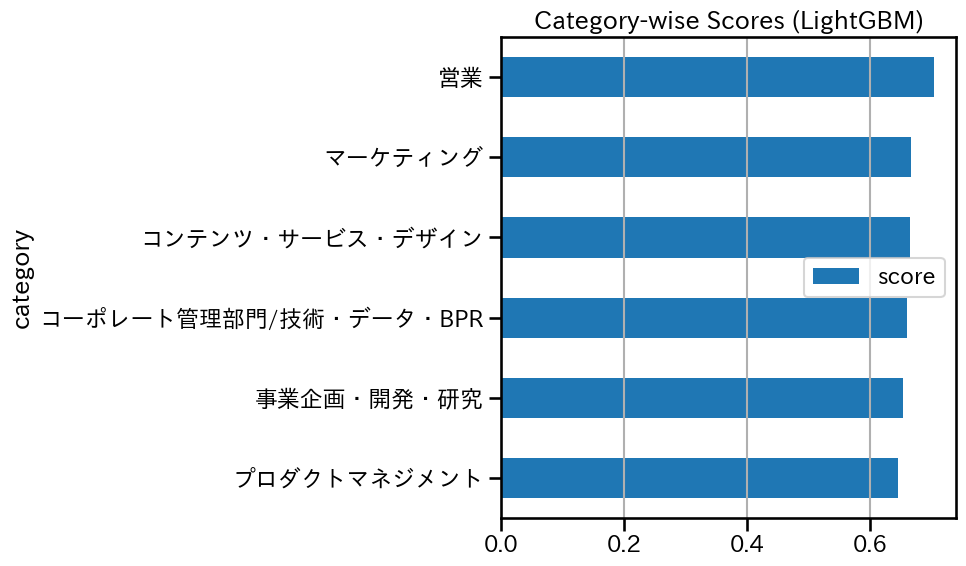


--- カテゴリ別スコア (XGBoost) ---


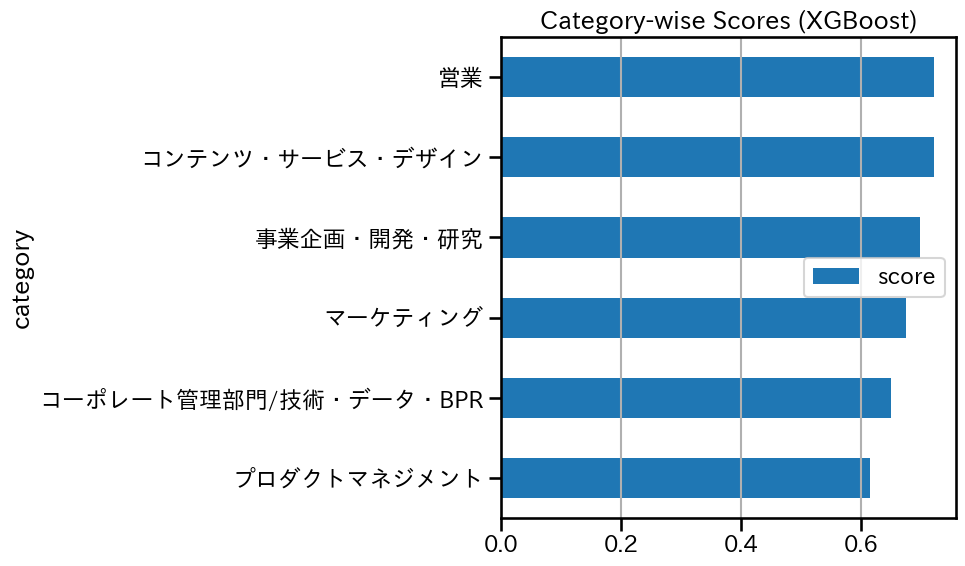

In [245]:
# 複数のカテゴリごとに応募有無を予測しなくてはならない
# どのカテゴリの予測が難しくて、どのカテゴリの予測が簡単なのかを把握しておくと良い
def analyze_category_scores(oof_preds, model_name):
    scores = []
    for cat_name, _df in df_train.groupby("category"):
        idx = _df.index
        # df_train_featのインデックスとoof_predsのインデックスが一致している前提
        score_i = roc_auc_score(df_train["target"].iloc[idx], oof_preds[idx])
        scores.append({"category": cat_name, "score": score_i})
    
    df_scores = pd.DataFrame(scores).set_index("category").sort_values("score")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    df_scores.plot(kind="barh", ax=ax) # 横棒グラフに変更して見やすくする
    ax.set_title(f'Category-wise Scores ({model_name})')
    ax.grid(axis='x')
    fig.tight_layout()
    plt.show()

print("\n--- カテゴリ別スコア (LightGBM) ---")
analyze_category_scores(oof, "LightGBM")

print("\n--- カテゴリ別スコア (XGBoost) ---")
analyze_category_scores(oof_xgb, "XGBoost")

# 部署ごとにどのくらい予測があたっているかを確認することができる。
# マーケティングをどうやって予測できるかなどを考えてみる→新たな特徴量を考える

C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\2173353882.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=feature_importance_df, x="feature_importance", y="column", order=order, ax=ax, palette="viridis", orient="h")


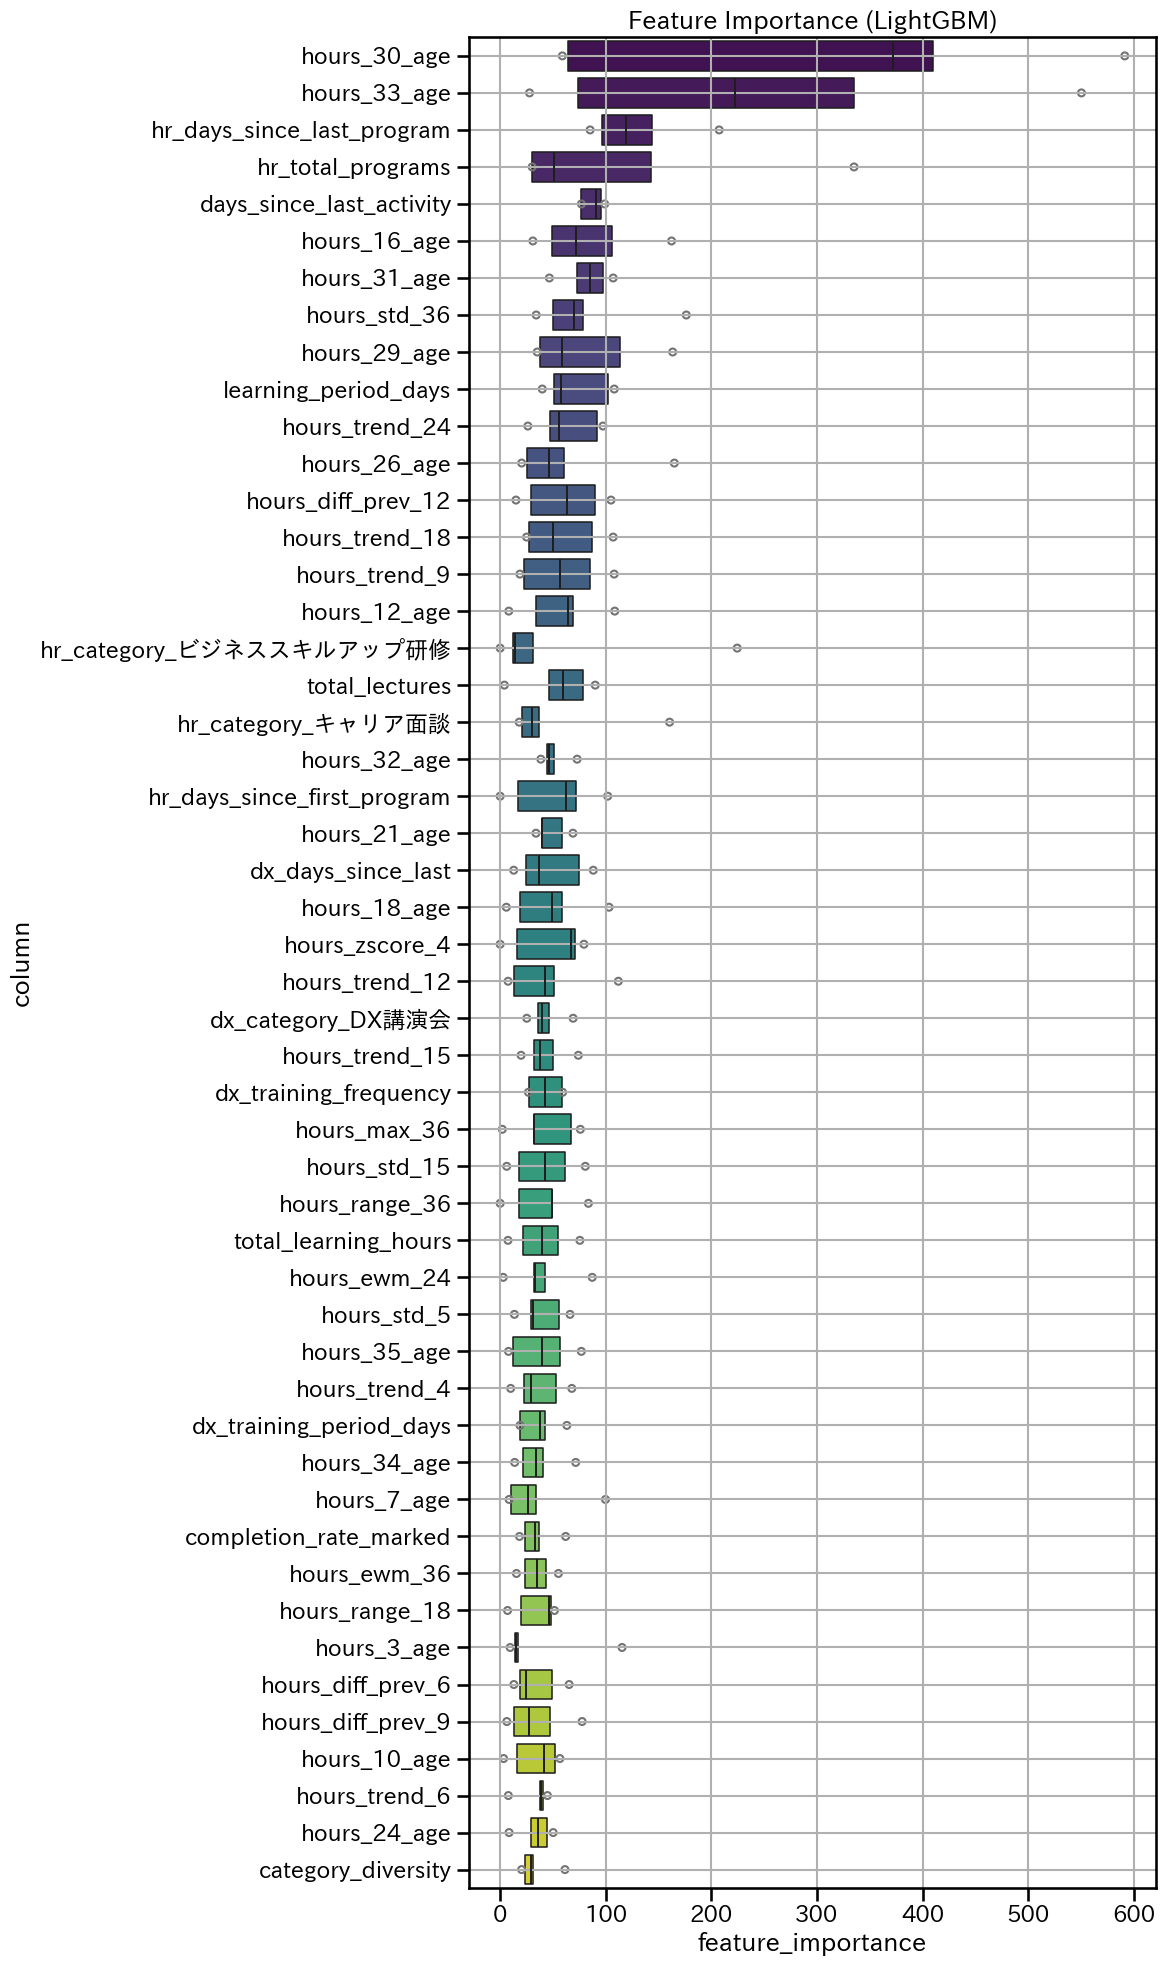

C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_20872\2173353882.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=feature_importance_df, x="feature_importance", y="column", order=order, ax=ax, palette="viridis", orient="h")


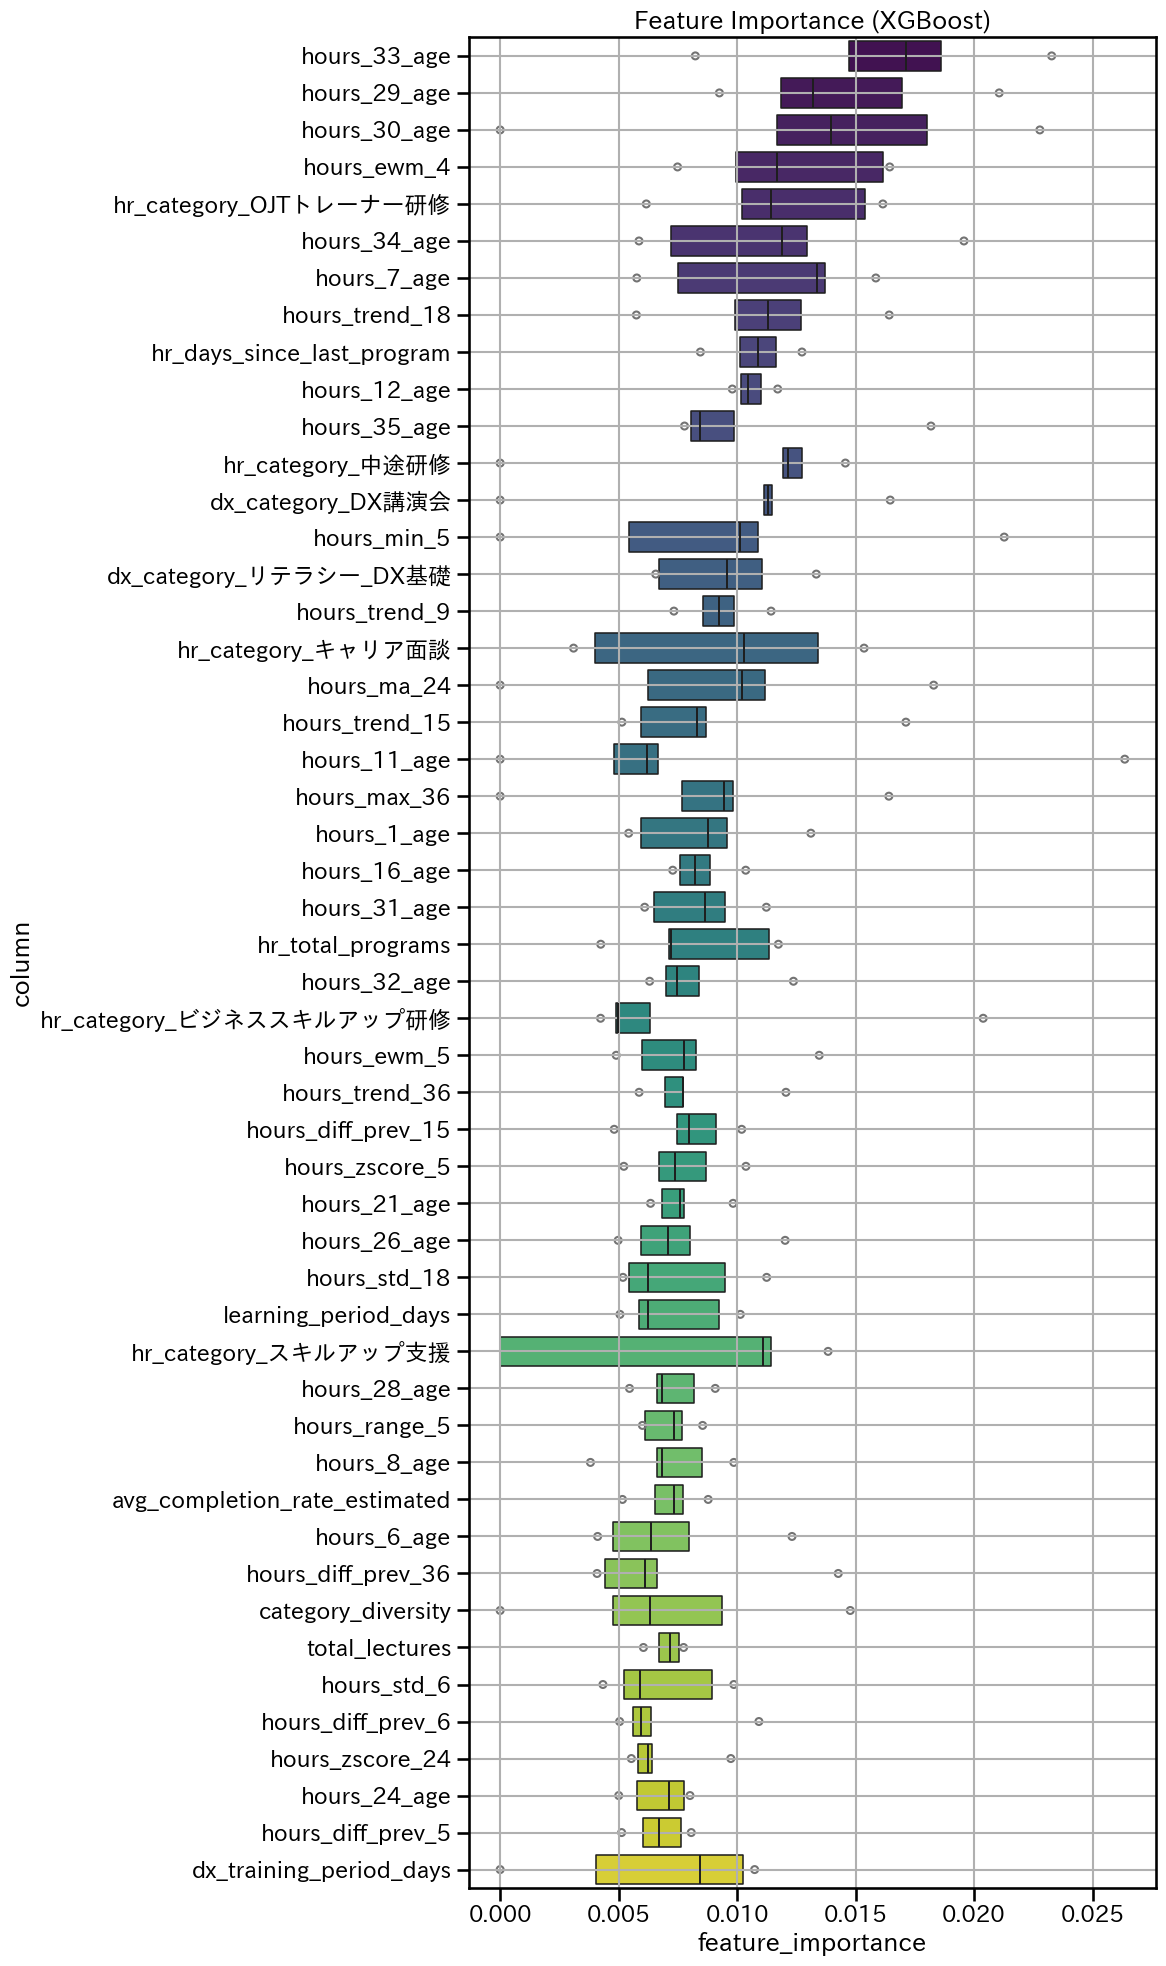

In [246]:
# 特徴重要度
# 大事な特徴量と大事ではない特徴量を探せる
# LightGBM用の特徴量重要度
def visualize_importance(models, feat_train_df, title):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)
        
    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]
    
    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .4)))
    sns.boxenplot(data=feature_importance_df, x="feature_importance", y="column", order=order, ax=ax, palette="viridis", orient="h")
    ax.set_title(title)
    ax.grid()
    fig.tight_layout()
    return fig, ax

# LightGBMの特徴量重要度
visualize_importance(models, X, "Feature Importance (LightGBM)")
plt.show()

# XGBoostの特徴量重要度
visualize_importance(models_xgb, X, "Feature Importance (XGBoost)")
plt.show()

In [247]:
# ===================================================================
# 4. 提出ファイルの作成
# ===================================================================
# --- LightGBMの予測 ---
predicts_lgbm = [model.predict_proba(X_test.values)[:, 1] for model in models]
predict_lgbm_avg = np.array(predicts_lgbm).mean(axis=0)
df_submission_lgbm = pd.DataFrame({'target': predict_lgbm_avg})

# --- XGBoostの予測 ---
predicts_xgb = [model.predict_proba(X_test.values)[:, 1] for model in models_xgb]
predict_xgb_avg = np.array(predicts_xgb).mean(axis=0)
df_submission_xgb = pd.DataFrame({'target': predict_xgb_avg})

# --- アンサンブル（平均）予測 ---
predict_ensemble_avg = (predict_lgbm_avg + predict_xgb_avg) / 2
df_submission_ensemble = pd.DataFrame({'target': predict_ensemble_avg})

# --- ファイルへの保存 ---
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

# 各モデルとアンサンブルのファイルを保存
filename_lgbm = f"{timestamp}_submission_lgbm.csv"
filename_xgb = f"{timestamp}_submission_xgb.csv"
filename_ensemble = f"{timestamp}_submission_ensemble.csv"

df_submission_lgbm.to_csv(os.path.join(OUTPUT_DIR, filename_lgbm), index=False)
df_submission_xgb.to_csv(os.path.join(OUTPUT_DIR, filename_xgb), index=False)
df_submission_ensemble.to_csv(os.path.join(OUTPUT_DIR, filename_ensemble), index=False)

print(f"\n--- 提出ファイルを作成しました ---")
print(f" - {filename_lgbm}")
print(f" - {filename_xgb}")
print(f" - {filename_ensemble} (アンサンブル)")


--- 提出ファイルを作成しました ---
 - 20250801_214151_submission_lgbm.csv
 - 20250801_214151_submission_xgb.csv
 - 20250801_214151_submission_ensemble.csv (アンサンブル)


In [248]:
# # --- 2. 各データの集計・加工 ---

# # 応募者データ（ターゲット）の作成
# df_target = df_train.groupby('社員番号')['target'].max().reset_index()

# # 最新の役職データを抽出
# df_position_latest = df_position.sort_values('year').groupby('社員番号').last().reset_index()

# # 残業時間の平均を算出
# df_overtime_avg = df_overtime.groupby('社員番号')['hours'].mean().reset_index()
# df_overtime_avg = df_overtime_avg.rename(columns={'hours': '月平均残業時間'})

# # 研修(hr)の受講回数をカウント
# df_hr_count = df_hr.groupby('社員番号').size().reset_index(name='研修受講回数')

# # DX研修の受講回数をカウント
# df_dx_count = df_dx.groupby('社員番号').size().reset_index(name='DX研修受講回数')

# # Udemyのアクティビティ数をカウント
# df_udemy_count = df_udemy.groupby('社員番号').size().reset_index(name='Udemyアクティビティ数')

# # キャリアアンケートのデータを加工
# # カラム名を短縮 (例: career_q1, career_q2...)
# original_career_columns = df_career.columns.tolist()
# new_career_columns = {col: f'career_q{i}' for i, col in enumerate(original_career_columns)}
# df_career_processed = df_career.rename(columns=new_career_columns)
# df_career_processed = df_career_processed.rename(columns={'career_q0': '社員番号'}) # 社員番号のカラム名は元に戻す

# # 回答の文字列からスコア（数字）を抽出する関数
# def extract_score(value):
#     if isinstance(value, str):
#         match = re.search(r'^(\d)', value.strip())
#         if match:
#             return int(match.group(1))
#     return None # 数値が見つからない場合はNone（欠損値）

# # 社員番号以外の全カラムに適用
# for col in df_career_processed.columns:
#     if col != '社員番号':
#         df_career_processed[col] = df_career_processed[col].apply(extract_score)


